In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit, ols

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.utils import concat_csv_with_indices

In [3]:
sns.set_context("paper", font_scale=2)

In [9]:
false_friends_path = "outputs/analogy/inputs/librispeech-test-clean/w2v2/false_friends.csv"
state_space_path = "outputs/analogy/inputs/librispeech-test-clean/w2v2/state_space_spec.h5"
most_common_allomorphs_path = "outputs/analogy/inputs/librispeech-test-clean/w2v2/most_common_allomorphs.csv"
cross_instances_path = "outputs/analogy/inputs/librispeech-test-clean/w2v2/all_cross_instances.parquet"
output_dir = "analogy_figures_heldout"

In [5]:
# Grouping variables on experiment results dataframe to select a single run
run_groupers = ["base_model_name", "model_name", "equivalence"]

# plot_runs = [(f"w2v2_{i}", "ff_32", "word_broad_10frames_fixedlen25") for i in range(12)] + \
#             [(f"w2v2_{i}", "discrim-ff_32", "word_broad_10frames_fixedlen25") for i in range(12)] + \
#             [(f"w2v2_{i}", "id", "id") for i in range(12)] + \
#             [(f"w2v2_{i}", "ffff_32", "word_broad_10frames_fixedlen25") for i in range(12)]
plot_runs = [(f"w2v2_{i}", "ffff_32", "word_broad_10frames_fixedlen25") for i in range(12)] + \
             [(f"w2v2_{i}", "id", "id") for i in range(12)]
# plot_runs = [("w2v2_8", "ff_32", "word_broad_10frames_fixedlen25"),]

main_plot_run = ("w2v2_8", "ffff_32", "word_broad_10frames_fixedlen25")
foil_plot_run = ("w2v2_8", "id", "id")
main_plot_name = "Word"
foil_plot_name = "Wav2Vec"
# main_plot_run = ("w2v2_8", "discrim-ff_32", "word_broad_10frames_fixedlen25")
# choose a vmin, vmax so that all heatmaps have the same color scale
main_plot_vmin, main_plot_vmax = 0.4, 0.9

plot_inflections = ["NNS", "VBZ"]
plot_metrics = ["correct", "gt_label_rank", "gt_distance"]

## Load metadata

In [6]:
word_freq_df = pd.read_csv("data/WorldLex_Eng_US.Freq.2.txt", sep="\t", index_col="Word")
# compute weighted average frequency across domains
word_freq_df["BlogFreq_rel"] = word_freq_df.BlogFreq / word_freq_df.BlogFreq.sum()
word_freq_df["TwitterFreq_rel"] = word_freq_df.TwitterFreq / word_freq_df.TwitterFreq.sum()
word_freq_df["NewsFreq_rel"] = word_freq_df.NewsFreq / word_freq_df.NewsFreq.sum()
word_freq_df["Freq"] = word_freq_df[["BlogFreq_rel", "TwitterFreq_rel", "NewsFreq_rel"]].mean(axis=1) \
    * word_freq_df[["BlogFreq", "TwitterFreq", "NewsFreq"]].sum().mean()
word_freq_df["LogFreq"] = np.log10(word_freq_df.Freq)

In [7]:
false_friends_df = pd.read_csv(false_friends_path)

In [10]:
most_common_allomorphs = pd.read_csv(most_common_allomorphs_path)

In [11]:
all_cross_instances = pd.read_parquet(cross_instances_path)

## Load results

In [103]:
all_results = concat_csv_with_indices(
        "outputs/analogy/runs/**/librispeech-test-clean/experiment_results.csv",
        [lambda p: p.parents[1].name, lambda p: p.parents[2].name,
            lambda p: p.parents[3].name],
        ["equivalence", "model_name", "base_model_name"]) \
    .droplevel(-1).reset_index()

In [104]:
all_id_results = concat_csv_with_indices(
        "outputs/analogy/runs_id/librispeech-test-clean/**/experiment_results.csv",
        [lambda p: p.parents[0].name],
        ["base_model_name"]) \
    .droplevel(-1).reset_index()
all_id_results["model_name"] = "id"
all_id_results["equivalence"] = "id"

In [105]:
all_results = pd.concat([all_results, all_id_results], ignore_index=True)

In [106]:
all_results["group"] = all_results.group.apply(lambda x: eval(x) if not (isinstance(x, float) and np.isnan(x)) else None)
all_results = all_results.reset_index()

### Exclusions

In [107]:
# post-hoc exclude some words which have base/inflected forms which are homophonous with items of another category
exclusions = [
    ("VBZ", "know"), # nose
    ("VBZ", "seem"), # seam
    ("VBZ", "please"), # pleas
    ("VBZ", "write"), # right
    ("VBZ", "meet"), # meat
    ("VBZ", "read"), # reed
]

In [108]:
# anti join
all_results = all_results.merge(pd.DataFrame(exclusions, columns=["inflection_from", "base_from"]),
                  on=["inflection_from", "base_from"], how="left", indicator=True) \
    .query("_merge == 'left_only'").drop(columns="_merge") \
    .merge(pd.DataFrame(exclusions, columns=["inflection_to", "base_to"]),
           on=["inflection_to", "base_to"], how="left", indicator=True) \
    .query("_merge == 'left_only'").drop(columns="_merge")

### Layer-wise

In [109]:
plot_lw = all_results.query("experiment == 'regular'").copy()
plot_lw = plot_lw.groupby(run_groupers + ["group", "inflection_from"])[["correct", "gt_label_rank", "gt_distance"]].mean()
plot_lw = plot_lw.reindex([(*plot_run, group, inflection_from)
                           for group in plot_lw.index.get_level_values("group").unique()
                           for inflection_from in plot_lw.index.get_level_values("inflection_from").unique()
                           for plot_run in plot_runs]).reset_index()
plot_lw["group0"] = plot_lw.group.apply(lambda x: x[0] if x is not None else None)
plot_lw["group1"] = plot_lw.group.apply(lambda x: x[1] if x is not None else None)
plot_lw["layer"] = plot_lw.base_model_name.str.extract(r"_(\d+)$").astype(int) + 1
plot_lw["model_name"] = plot_lw["model_name"].map({"id": "Wav2Vec", main_plot_run[1]: "Word"})

lw_random = plot_lw[plot_lw.group0 == "random"].groupby(["inflection_from", "layer"])[["correct", "gt_label_rank"]].mean().reset_index().dropna()

plot_lw = plot_lw[plot_lw.inflection_from.isin(plot_inflections)]
plot_lw = plot_lw[(plot_lw.group1 == True)]

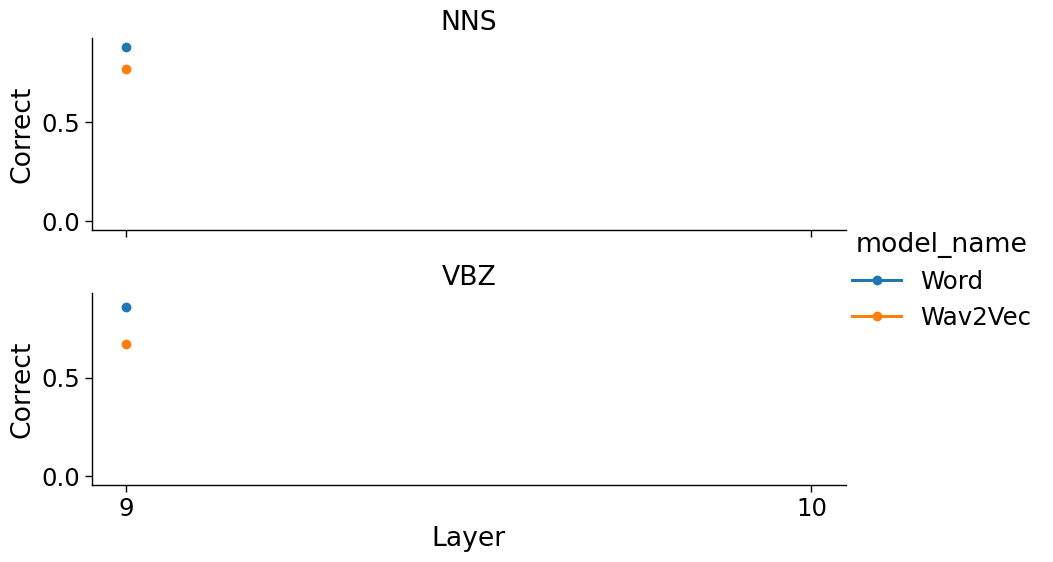

In [110]:
g = sns.catplot(data=plot_lw, x="layer", y="correct", hue="model_name", row="inflection_from",
                kind="point", height=3, aspect=3)

for ax, row_name in zip(g.axes.flat, g.row_names):
    sns.lineplot(data=lw_random,
                 x="layer", y="correct", ax=ax, color="gray", linestyle="--",
                 legend=None)
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_ylabel("Correct")
    if ax.get_xlabel() == "layer":
        ax.set_xlabel("Layer")

# g.figure.tight_layout()
g.figure.savefig(f"{output_dir}/layer_wise.pdf")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

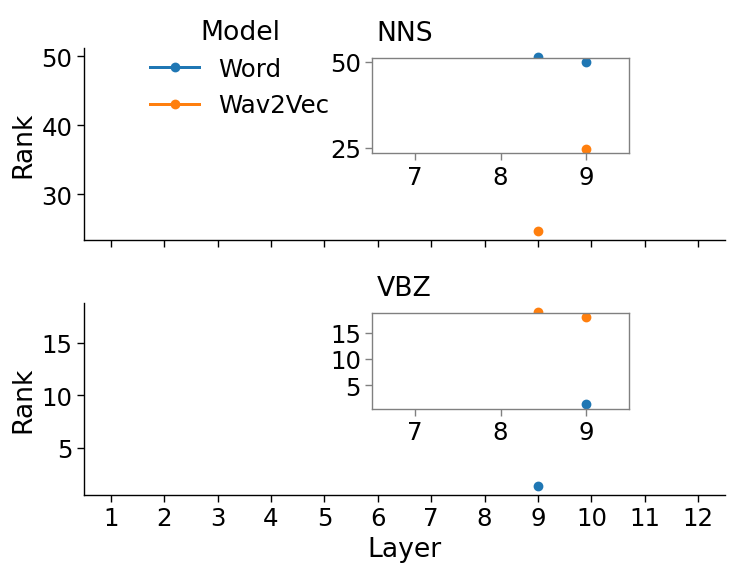

In [111]:
hue_order = ["Word", "Wav2Vec"]
g = sns.catplot(data=plot_lw, x="layer", y="gt_label_rank",
                hue="model_name", hue_order=hue_order,
                row="inflection_from", row_order=plot_inflections,
                kind="point", sharey=False, height=3, aspect=1.25)

for (row, col, hue), data in g.facet_data():
    ax = g.axes[row, col]
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_ylabel("Rank")
    if ax.get_xlabel() == "layer":
        ax.set_xlabel("Layer")

    # Add an inset showing the middle layers
    inset_ax = ax.inset_axes([0.45, 0.45, 0.4, 0.5])
    sns.pointplot(data=data[data.layer.between(7, 9)], x="layer", y="gt_label_rank",
                  hue="model_name", hue_order=hue_order,
                  ax=inset_ax, legend=None)
    inset_ax.set_xlabel(None)
    inset_ax.set_ylabel(None)
    for spine in inset_ax.spines.values():
        spine.set_edgecolor("gray")
    inset_ax.tick_params(color="gray")

g.legend.remove()
g.add_legend(title="Model", bbox_to_anchor=(0.19, 0.99), loc="upper left")
g.figure.tight_layout()
g.figure.savefig(f"{output_dir}/layer_wise-rank.pdf")

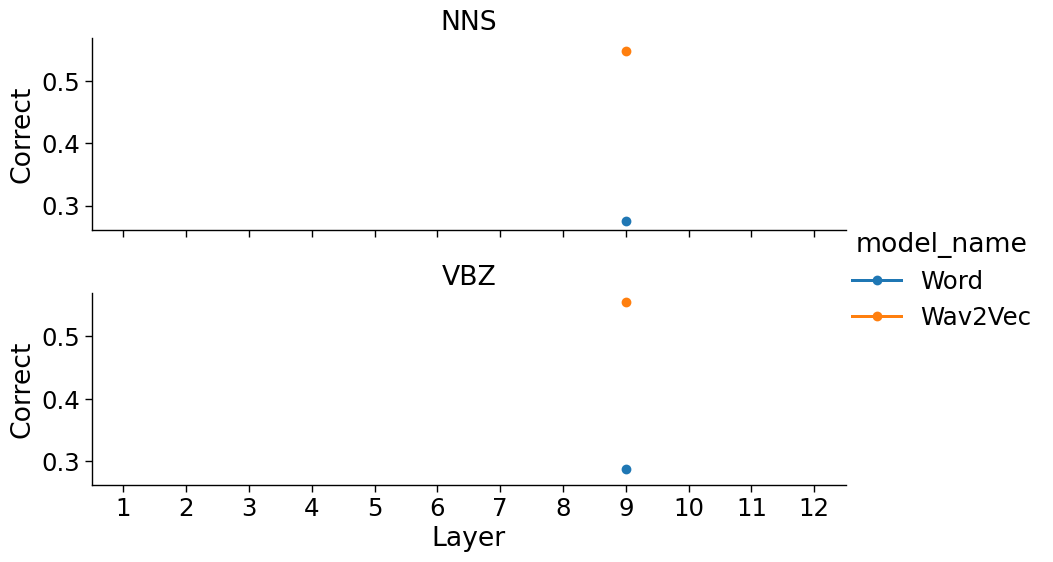

In [112]:
g = sns.catplot(data=plot_lw, x="layer", y="gt_distance", hue="model_name", row="inflection_from",
                kind="point", height=3, aspect=3)

for ax, row_name in zip(g.axes.flat, g.row_names):
    # sns.lineplot(data=lw_random,
    #              x="layer", y="gt_label_rank", ax=ax, color="gray", linestyle="--",
    #              legend=None)
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_ylabel("Correct")
    if ax.get_xlabel() == "layer":
        ax.set_xlabel("Layer")

# g.figure.tight_layout()
g.figure.savefig(f"{output_dir}/layer_wise-distance.pdf")

## Compute controlled NNVB results

In [113]:
all_nnvb_results = []

for run, run_results in all_results.groupby(run_groupers):
    run_results = run_results.set_index("experiment")
    nnvb_expts = run_results.index.unique()
    nnvb_expts = nnvb_expts[nnvb_expts.str.contains("unambiguous-")]

    for expt in nnvb_expts:
        inflection_from, allomorph_from, inflection_to, allomorph_to = \
            re.findall(r"unambiguous-(\w+)_([\w\s]+)_to_(\w+)_([\w\s]+)", expt)[0]
        expt_df = run_results.loc[[expt]].copy()

        num_seen_words = min(len(expt_df.base_from.unique()), len(expt_df.base_to.unique()))
        # DEV
        # if num_seen_words < 10:
        #     print(f"Skipping {expt} due to only {num_seen_words} seen words")
        #     continue

        expt_df["inflection_from"] = inflection_from
        expt_df["allomorph_from"] = allomorph_from
        expt_df["inflection_to"] = inflection_to
        expt_df["allomorph_to"] = allomorph_to

        all_nnvb_results.append(expt_df)

all_nnvb_results = pd.concat(all_nnvb_results)

all_nnvb_results["inflected_from"] = all_nnvb_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_nnvb_results["inflected_to"] = all_nnvb_results.to_equiv_label.apply(lambda x: eval(x)[1])

all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("from_base_freq"),
                            left_on="base_from", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("to_base_freq"),
                              left_on="base_to", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

all_nnvb_results["from_freq"] = all_nnvb_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_nnvb_results["to_freq"] = all_nnvb_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, frequency_bins = pd.qcut(pd.concat([all_nnvb_results.to_freq, all_nnvb_results.from_freq]), q=5, retbins=True)
all_nnvb_results["to_freq_bin"] = pd.cut(all_nnvb_results.to_freq, bins=frequency_bins, labels=[f"Q{i}" for i in range(1, 6)])
all_nnvb_results["from_freq_bin"] = pd.cut(all_nnvb_results.from_freq, bins=frequency_bins, labels=[f"Q{i}" for i in range(1, 6)])

In [114]:
def summarize_nnvb_run(rows):
    rows["source_label"] = rows.inflection_from + " " + rows.allomorph_from
    rows["target_label"] = rows.inflection_to + " " + rows.allomorph_to

    rows["transfer_label"] = rows.inflection_from + " -> " + rows.inflection_to
    rows["phon_label"] = rows.allomorph_from + " " + rows.allomorph_to

    # only retain cases where we have data in both transfer directions from source <-> target within inflection
    rows["complement_exists"] = rows.apply(lambda row: len(rows.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
    rows = rows.query("complement_exists > 0").drop(columns=["complement_exists"])

    return rows

summary_groupers = ["inflection_from", "inflection_to", "allomorph_from", "allomorph_to"]
nnvb_results_summary = all_nnvb_results.groupby(run_groupers + summary_groupers) \
    .correct.agg(["count", "mean"]) \
    .query("count >= 0") \
    .reset_index(summary_groupers) \
    .groupby(run_groupers, group_keys=False) \
    .apply(summarize_nnvb_run) \
    .reset_index()

nnvb_results_summary

base_model_name model_name                     equivalence inflection_from  \
0           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
1           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
2           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
3           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
4           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
5           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
6           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
7           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
8           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
9           w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
10          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
11          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
12          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
13          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             NNS   
14          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
15          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
16          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
17          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
18          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
19          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
20          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
21          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
22          w2v2_8    ffff_32  word_broad_10frames_fixedlen25             VBZ   
23          w2v2_8         id                              id             NNS   
24          w2v2_8         id                              id             NNS   
25          w2v2_8         id                              id             NNS   
26          w2v2_8         id                              id             NNS   
27          w2v2_8         id                              id             NNS   
28          w2v2_8         id                              id             NNS   
29          w2v2_8         id                              id             NNS   
30          w2v2_8         id                              id             NNS   
31          w2v2_8         id                              id             NNS   
32          w2v2_8         id                              id             NNS   
33          w2v2_8         id                              id             NNS   
34          w2v2_8         id                              id             NNS   
35          w2v2_8         id                              id             NNS   
36          w2v2_8         id                              id             NNS   
37          w2v2_8         id                              id             VBZ   
38          w2v2_8         id                              id             VBZ   
39          w2v2_8         id                              id             VBZ   
40          w2v2_8         id                              id             VBZ   
41          w2v2_8         id                              id             VBZ   
42          w2v2_8         id                              id             VBZ   
43          w2v2_8         id                              id             VBZ   
44          w2v2_8         id                              id             VBZ   
45          w2v2_8         id                              id             VBZ   

   inflection_to allomorph_from allomorph_to  count      mean source_label  \
0            NNS           IH Z         IH Z      6  1.000000     NNS IH Z   
1            NNS           IH Z        

In [115]:
# plot_results = []
# for base_model_name, model_name, equivalence in plot_runs:
#     results_i = nnvb_results_summary.query("base_model_name == @base_model_name and model_name == @model_name and equivalence == @equivalence")
#     if len(results_i) > 0:
#         plot_results.append(results_i)
# num_plot_runs = len(plot_results)

# ncols = 4
# nrows = int(np.ceil(num_plot_runs / ncols))
# f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

# for ax, results_i in zip(axs.flat, plot_results):
#     sns.heatmap(results_i.set_index(["source_label", "target_label"])["mean"].unstack(),
#                 vmin=0, vmax=1, ax=ax)
#     key_row = results_i.iloc[0]
#     ax.set_title(f"{key_row.base_model_name} -> {key_row.model_name} ({key_row.equivalence})")

### Focused plots

In [116]:
focus_base_model, focus_model, focus_equivalence = main_plot_run
foil_base_model, foil_model, foil_equivalence = "w2v2_8", "id", "id"

nnvb_focus = all_nnvb_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
nnvb_foil = all_nnvb_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")
nnvb_focus["model_label"] = "Word"
nnvb_foil["model_label"] = "Wav2Vec"

nnvb_focus = pd.concat([nnvb_focus, nnvb_foil])

allomorph_labels = {"Z": "z", "S": "s", "IH Z": "ɪz"}
nnvb_focus["allomorph_from"] = nnvb_focus.allomorph_from.map(allomorph_labels)
nnvb_focus["allomorph_to"] = nnvb_focus.allomorph_to.map(allomorph_labels)
nnvb_focus

/tmp/ipykernel_3556554/3874715788.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnvb_focus["model_label"] = "Word"
/tmp/ipykernel_3556554/3874715788.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnvb_foil["model_label"] = "Wav2Vec"


index                     equivalence  \
experiment                                                             
unambiguous-NNS_Z_to_NNS_Z     14190  word_broad_10frames_fixedlen25   
unambiguous-NNS_Z_to_NNS_Z     14191  word_broad_10frames_fixedlen25   
unambiguous-NNS_Z_to_NNS_Z     14192  word_broad_10frames_fixedlen25   
unambiguous-NNS_Z_to_NNS_Z     14193  word_broad_10frames_fixedlen25   
unambiguous-NNS_Z_to_NNS_Z     14194  word_broad_10frames_fixedlen25   
...                              ...                             ...   
unambiguous-VBZ_Z_to_VBZ_Z     33496                              id   
unambiguous-VBZ_Z_to_VBZ_IH Z  33498                              id   
unambiguous-VBZ_Z_to_VBZ_IH Z  33500                              id   
unambiguous-VBZ_IH Z_to_VBZ_Z  33502                              id   
unambiguous-VBZ_IH Z_to_VBZ_Z  33504                              id   

                              model_name base_model_name  Unnamed: 1 group  \
experiment                                                                   
unambiguous-NNS_Z_to_NNS_Z       ffff_32          w2v2_8           0  None   
unambiguous-NNS_Z_to_NNS_Z       ffff_32          w2v2_8           1  None   
unambiguous-NNS_Z_to_NNS_Z       ffff_32          w2v2_8           2  None   
unambiguous-NNS_Z_to_NNS_Z       ffff_32          w2v2_8           3  None   
unambiguous-NNS_Z_to_NNS_Z       ffff_32          w2v2_8           4  None   
...                                  ...             ...         ...   ...   
unambiguous-VBZ_Z_to_VBZ_Z            id          w2v2_8          10  None   
unambiguous-VBZ_Z_to_VBZ_IH Z         id          w2v2_8           0  None   
unambiguous-VBZ_Z_to_VBZ_IH Z         id          w2v2_8           2  None   
unambiguous-VBZ_IH Z_to_VBZ_Z         id          w2v2_8           0  None   
unambiguous-VBZ_IH Z_to_VBZ_Z         id          w2v2_8           2  None   

                                    from_equiv_label         to_equiv_label  \
experiment                                                                    
unambiguous-NNS_Z_to_NNS_Z       ('cloud', 'clouds')  ('window', 'windows')   
unambiguous-NNS_Z_to_NNS_Z         ('idea', 'ideas')  ('friend', 'friends')   
unambiguous-NNS_Z_to_NNS_Z     ('friend', 'friends')      ('word', 'words')   
unambiguous-NNS_Z_to_NNS_Z         ('idea', 'ideas')      ('word', 'words')   
unambiguous-NNS_Z_to_NNS_Z     ('person', 'persons')  ('friend', 'friends')   
...                                              ...                    ...   
unambiguous-VBZ_Z_to_VBZ_Z         ('come', 'comes')  ('become', 'becomes')   
unambiguous-VBZ_Z_to_VBZ_IH Z      ('come', 'comes')         ('do', 'does')   
unambiguous-VBZ_Z_to_VBZ_IH Z  ('become', 'becomes')         ('do', 'does')   
unambiguous-VBZ_IH Z_to_VBZ_Z         ('do', 'does')      ('come', 'comes')   
unambiguous-VBZ_IH Z_to_VBZ_Z         ('do', 'does')  ('become', 'becomes')   

                              base_from base_to  ... inflected_to  \
experiment                                       ...                
unambiguous-NNS_Z_to_NNS_Z        cloud  window  ...      windows   
unambiguous-NNS_Z_to_NNS_Z         idea  friend  ...      friends   
unambiguous-NNS_Z_to_NNS_Z       friend    word  ...        words   
unambiguous-NNS_Z_to_NNS_Z         idea    word  ...        words   
unambiguous-NNS_Z_to_NNS_Z       person  friend  ...      friends   
...                                 ...     ...  ...          ...   
unambiguous-VBZ_Z_to_VBZ_Z         come  become  ...      becomes   
unambiguous-VBZ_Z_to_VBZ_IH Z      come      do  ...         does   
unambiguous-VBZ_Z_to_VBZ_IH Z    become      do  ...         does   
unambiguous-VBZ_IH Z_to_VBZ_Z        do    come  ...        comes   
unambiguous-VBZ_IH Z_to_VBZ_Z        do  become  ...      becomes   

                              from_base_freq  from_inflected_freq  \
experiment                                                          
unambiguous-NNS

In [117]:
nnvb_results_summary = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to",
                                             "allomorph_from", "allomorph_to"]) \
    [plot_metrics].mean() \
    .reset_index().astype({"correct": float})

nnvb_results_summary["source_label"] = nnvb_results_summary.inflection_from + "\n" + nnvb_results_summary.allomorph_from
nnvb_results_summary["target_label"] = nnvb_results_summary.inflection_to + "\n" + nnvb_results_summary.allomorph_to

nnvb_results_summary["transfer_label"] = nnvb_results_summary.inflection_from + " -> " + nnvb_results_summary.inflection_to
nnvb_results_summary["phon_label"] = nnvb_results_summary.allomorph_from + " " + nnvb_results_summary.allomorph_to

# only retain cases where we have data in both transfer directions from source <-> target within inflection
nnvb_results_summary["complement_exists"] = nnvb_results_summary.apply(lambda row: len(nnvb_results_summary.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
nnvb_results_summary = nnvb_results_summary.query("complement_exists > 0").drop(columns=["complement_exists"])

# drop VBZ IH Z, which only has 4 word types
nnvb_results_summary = nnvb_results_summary[(nnvb_results_summary.source_label != "VBZ\nɪz") & (nnvb_results_summary.target_label != "VBZ\nɪz")]

nnvb_results_summary

model_label inflection_from inflection_to allomorph_from allomorph_to  \
0      Wav2Vec             NNS           NNS              s            z   
1      Wav2Vec             NNS           NNS              s           ɪz   
2      Wav2Vec             NNS           NNS              z            s   
3      Wav2Vec             NNS           NNS              z            z   
4      Wav2Vec             NNS           NNS              z           ɪz   
5      Wav2Vec             NNS           NNS             ɪz            s   
6      Wav2Vec             NNS           NNS             ɪz            z   
7      Wav2Vec             NNS           NNS             ɪz           ɪz   
8      Wav2Vec             NNS           VBZ              s            z   
10     Wav2Vec             NNS           VBZ              z            z   
12     Wav2Vec             NNS           VBZ             ɪz            z   
14     Wav2Vec             VBZ           NNS              z            s   
15     Wav2Vec             VBZ           NNS              z            z   
16     Wav2Vec             VBZ           NNS              z           ɪz   
20     Wav2Vec             VBZ           VBZ              z            z   
23        Word             NNS           NNS              s            z   
24        Word             NNS           NNS              s           ɪz   
25        Word             NNS           NNS              z            s   
26        Word             NNS           NNS              z            z   
27        Word             NNS           NNS              z           ɪz   
28        Word             NNS           NNS             ɪz            s   
29        Word             NNS           NNS             ɪz            z   
30        Word             NNS           NNS             ɪz           ɪz   
31        Word             NNS           VBZ              s            z   
33        Word             NNS           VBZ              z            z   
35        Word             NNS           VBZ             ɪz            z   
37        Word             VBZ           NNS              z            s   
38        Word             VBZ           NNS              z            z   
39        Word             VBZ           NNS              z           ɪz   
43        Word             VBZ           VBZ              z            z   

     correct  gt_label_rank  gt_distance source_label target_label  \
0   0.882353       0.176471     0.533308       NNS\ns       NNS\nz   
1   0.666667       3.000000     0.531556       NNS\ns      NNS\nɪz   
2   1.000000       0.000000     0.550026       NNS\nz       NNS\ns   
3   0.893382       2.698529     0.537172       NNS\nz       NNS\nz   
4   0.666667       1.078431     0.536292       NNS\nz      NNS\nɪz   
5   1.000000       0.000000     0.503989      NNS\nɪz       NNS\ns   
6   0.568627      21.313725     0.489218      NNS\nɪz       NNS\nz   
7   0.500000       2.000000     0.491743      NNS\nɪz      NNS\nɪz   
8   0.500000       2.000000     0.579038       NNS\ns       VBZ\nz   
10  0.735294       6.794118     0.585728       NNS\nz       VBZ\nz   
12  0.333333      22.666667     0.512602      NNS\nɪz       VBZ\nz   
14  1.000000       0.000000     0.577697       VBZ\nz       NNS\ns   
15  0.911765       0.088235     0.574176       VBZ\nz       NNS\nz   
16  0.666667       0.666667     0.570982       VBZ\nz      NNS\nɪz   
20  0.000000       3.500000     0.591022       VBZ\nz       VBZ\nz   
23  1.000000       0.000000     0.222783       NNS\ns       NNS\nz   
24  1.000000       0.000000     0.181122       NNS\ns      NNS\nɪz   
25  1.000000       0.000000     0.206772       NNS\nz       NNS\ns   
26  0.985294       0.033088     0.244262       NNS\nz       NNS\nz   
27  1.000000       0.000000     0.196582       NNS\nz      NNS\nɪz   
28  0.666667       0.666667     0.282610      NNS\nɪz       NNS\ns   
29  0.803922       0.745098     0.285171      NNS\nɪz       NNS\nz   
30  1.000000       0.000000     0.18

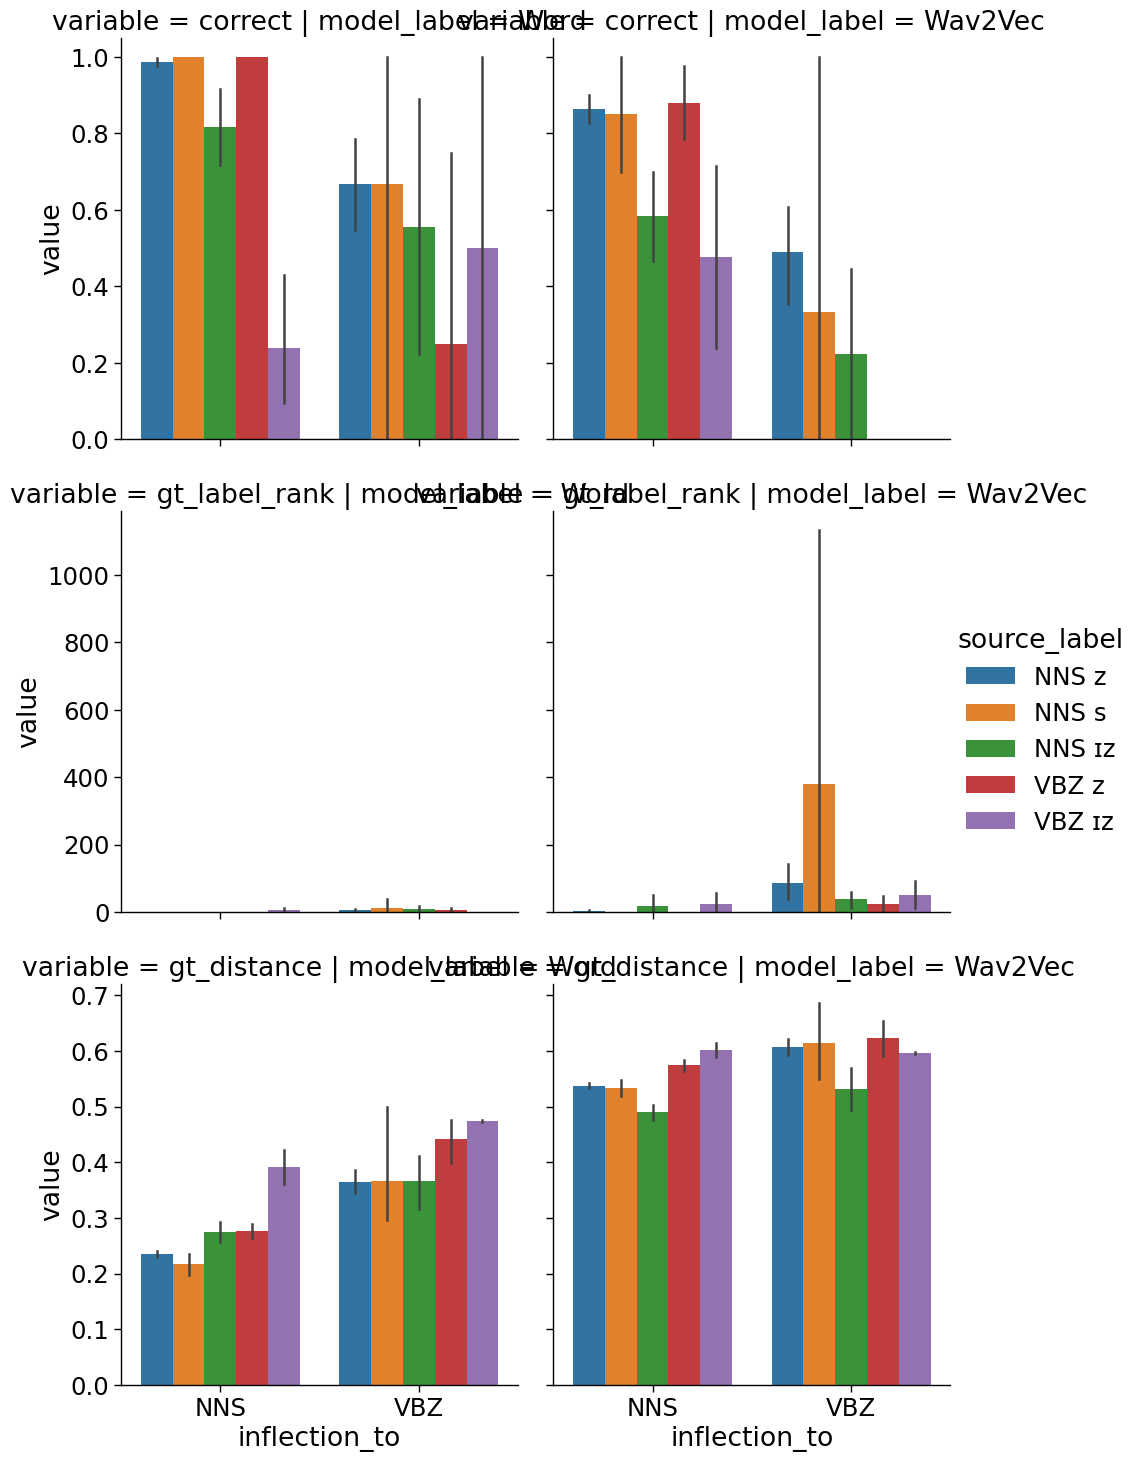

In [118]:
g = sns.catplot(data=nnvb_focus.melt(id_vars=["inflection_from", "allomorph_from", "inflection_to", "model_label"], value_vars=plot_metrics)
                        .assign(source_label=lambda xs: xs.inflection_from + " " + xs.allomorph_from),
                x="inflection_to", hue="source_label", y="value", col="model_label", row="variable", kind="bar", sharey="row")

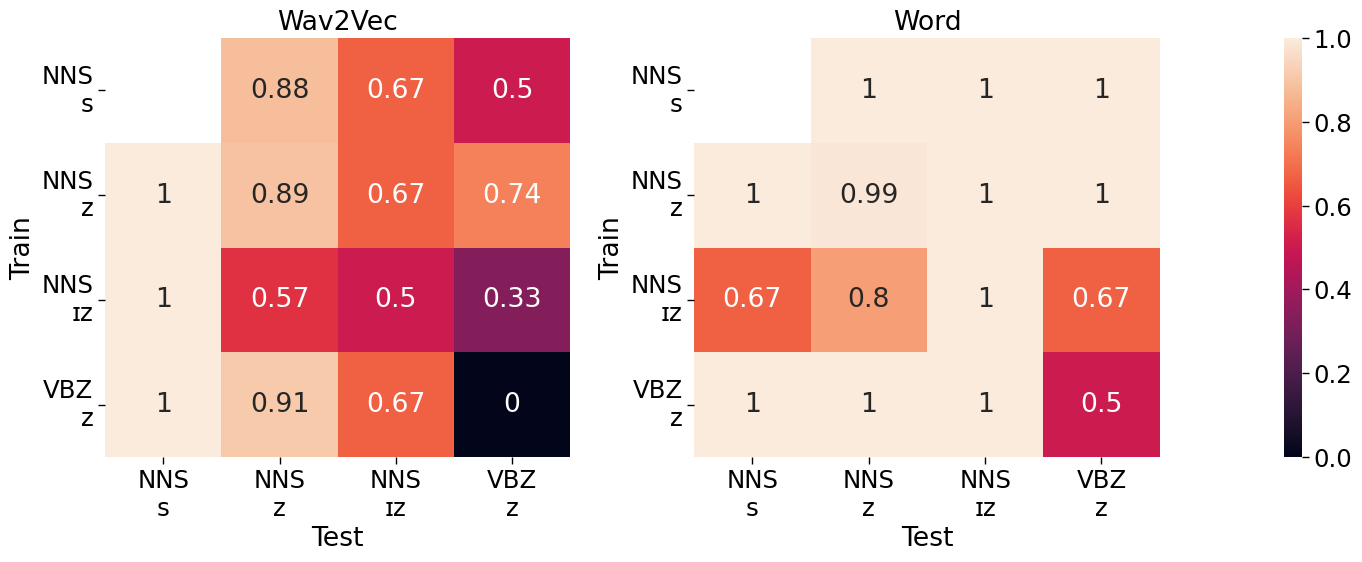

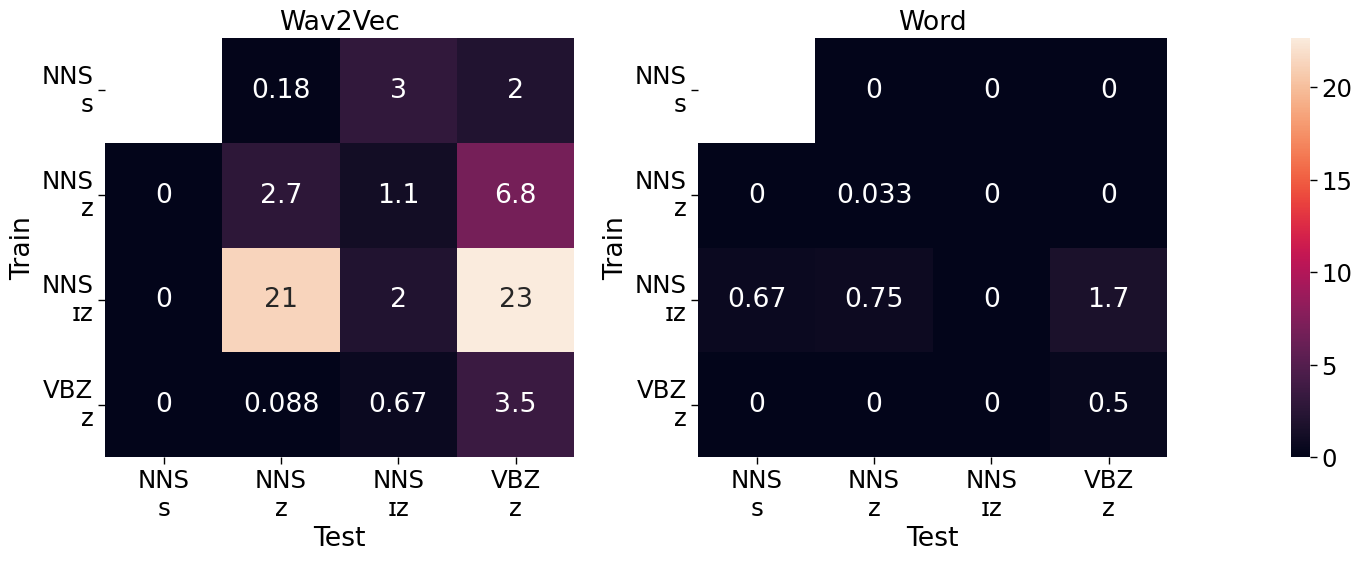

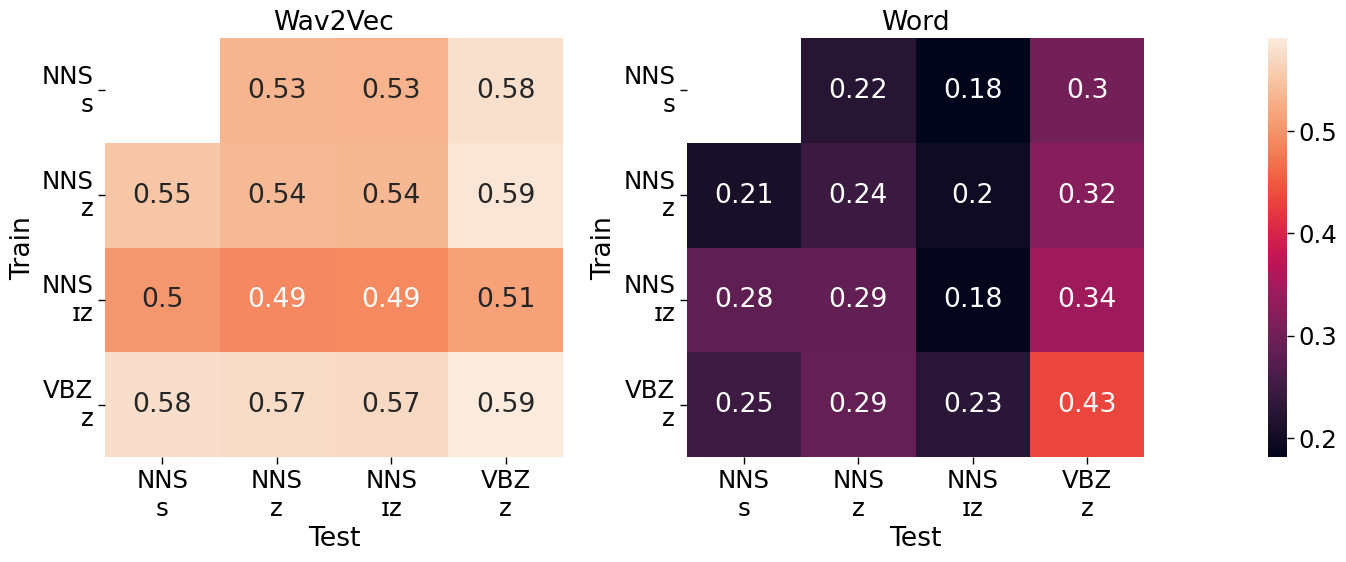

In [119]:
for metric in plot_metrics:
    vmin = 0 if metric == "correct" else nnvb_results_summary[metric].min()
    vmax = nnvb_results_summary[metric].max()

    f, axs = plt.subplots(1, 3, figsize=(7 * 2, 6), gridspec_kw={'width_ratios': [1, 1, 0.04]})
    # f.suptitle(f"{metric}", fontsize=20)
    for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary.groupby("model_label"))):
        cbar_ax = None
        if i == 1:
            cbar_ax = axs.flat[-1]

        ax.set_title(model_label)
        sns.heatmap(rows.set_index(["source_label", "target_label"]).sort_index()[metric].unstack("target_label"),
                    vmin=vmin, vmax=vmax,
                    annot=True, fmt=".2g", ax=ax,
                    cbar=i == 1, cbar_ax=cbar_ax)

        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_ylabel("Train")
        ax.set_xlabel("Test")

    f.tight_layout()
    f.savefig(f"{output_dir}/nnvb_allomorphs-{metric}.pdf", bbox_inches="tight")

In [120]:
nnvb_results_summary2 = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to"]) \
    [plot_metrics].mean().reset_index().astype({"correct": float})

nnvb_results_summary2["transfer_label"] = nnvb_results_summary2.inflection_from + " -> " + nnvb_results_summary2.inflection_to
nnvb_results_summary2

model_label inflection_from inflection_to   correct  gt_label_rank  \
0     Wav2Vec             NNS           NNS  0.823810       4.523810   
1     Wav2Vec             NNS           VBZ  0.444444      92.333333   
2     Wav2Vec             VBZ           NNS  0.746032       8.365079   
3     Wav2Vec             VBZ           VBZ  0.000000      34.166667   
4        Word             NNS           NNS  0.964286       0.116667   
5        Word             NNS           VBZ  0.650794       6.396825   
6        Word             VBZ           NNS  0.746032       2.095238   
7        Word             VBZ           VBZ  0.333333       4.333333   

   gt_distance transfer_label  
0     0.530680     NNS -> NNS  
1     0.596571     NNS -> VBZ  
2     0.583196     VBZ -> NNS  
3     0.613593     VBZ -> VBZ  
4     0.240027     NNS -> NNS  
5     0.364569     NNS -> VBZ  
6     0.314899     VBZ -> NNS  
7     0.452266     VBZ -> VBZ

/tmp/ipykernel_3556554/402605089.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
/tmp/ipykernel_3556554/402605089.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
/tmp/ipykernel_3556554/402605089.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


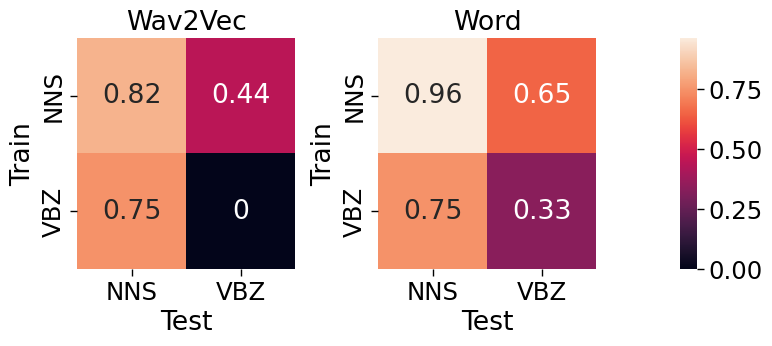

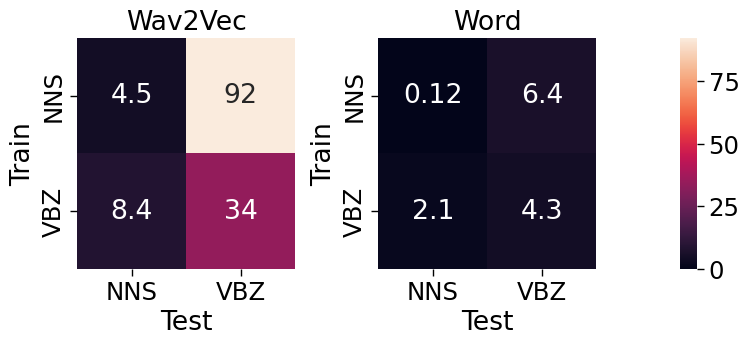

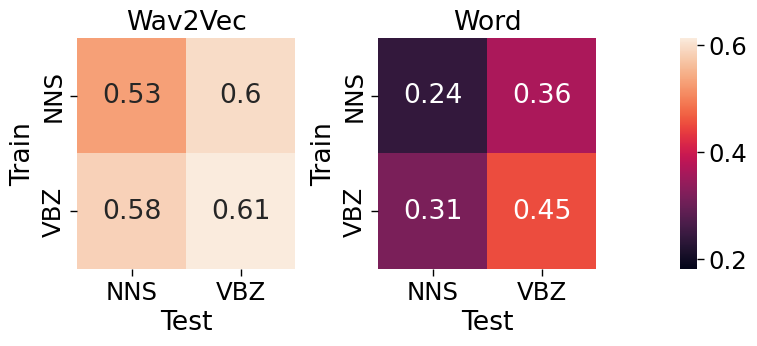

In [121]:
from matplotlib.gridspec import GridSpec


for metric in plot_metrics:
    vmin = 0 if metric == "correct" else nnvb_results_summary[metric].min()
    vmax = nnvb_results_summary2[metric].max()

    f = plt.figure(figsize=(3 * 2 + 2, 3))
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.08],
                  wspace=0.55)

    axs = [f.add_subplot(gs[0]), f.add_subplot(gs[1])]
    cbar_ax = f.add_subplot(gs[2])

    for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary2.groupby("model_label"))):
        cbar_ax_i = None
        if i == 1:
            cbar_ax_i = cbar_ax
        
        ax.set_title(model_label)
        sns.heatmap(rows.set_index(["inflection_from", "inflection_to"])[metric].unstack(),
                    annot=True, vmin=vmin, vmax=vmax, ax=ax,
                    cbar=i == 1, cbar_ax=cbar_ax)
        ax.set_xlabel("Test")
        ax.set_ylabel("Train")

    f = plt.gcf()
    f.tight_layout()
    f.savefig(f"{output_dir}/nnvb_results-{metric}.pdf", bbox_inches="tight")

Text(93.98077500000004, 0.5, 'Rank')

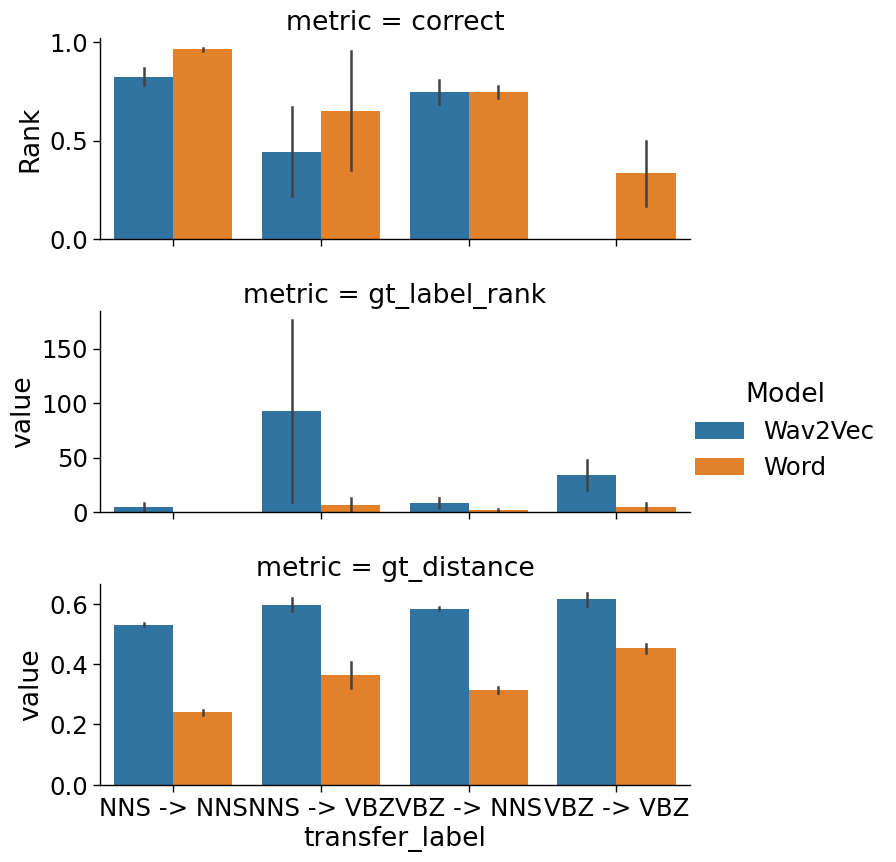

In [122]:
nnvb_plot = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to", "base_to"])[plot_metrics].mean().reset_index() \
    .melt(id_vars=["model_label", "inflection_from", "inflection_to", "base_to"],
          value_vars=plot_metrics, var_name="metric", value_name="value")
nnvb_plot["transfer_label"] = nnvb_plot.inflection_from + " -> " + nnvb_plot.inflection_to
g = sns.catplot(data=nnvb_plot, x="transfer_label", y="value", kind="bar", hue="model_label", row="metric", sharey="row",
                errorbar="se", height=3, aspect=2.5)
g._legend.set_title("Model")
ax = g.axes.flat[0]

ax.set_xlabel("Evaluation")
ax.set_ylabel("Rank")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


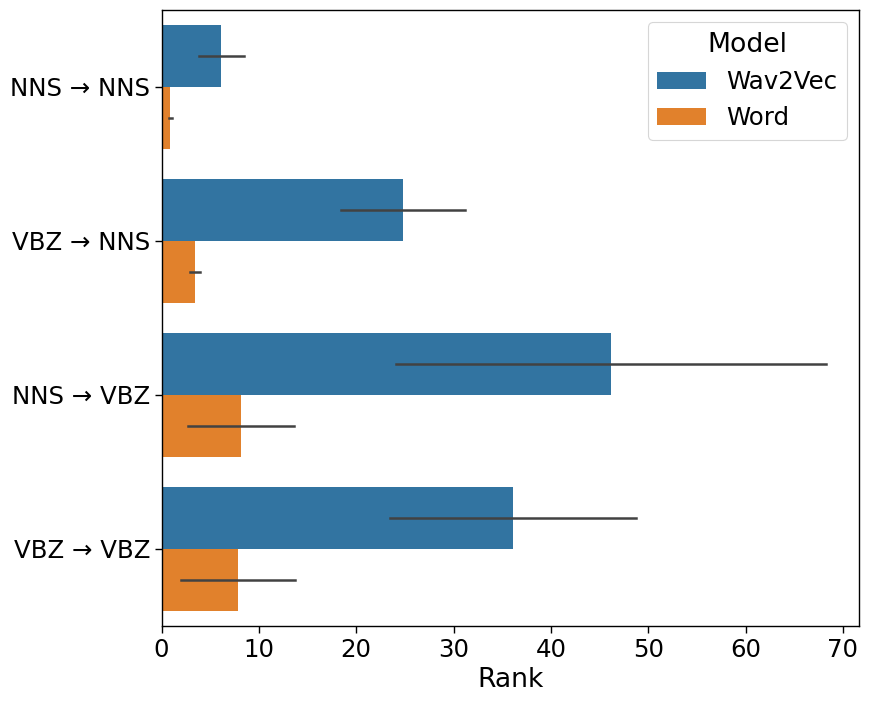

In [44]:
f, ax = plt.subplots(figsize=(9, 8))

transfer_label_pretty = {
    "NNS -> NNS": "NNS → NNS",
    "VBZ -> NNS": "VBZ → NNS",
    "NNS -> VBZ": "NNS → VBZ",
    "VBZ -> VBZ": "VBZ → VBZ",
}
ax = sns.barplot(data=nnvb_plot.set_index(sorted(set(nnvb_plot.columns) - {"value"}))
                    .value.unstack("metric").reset_index()
                    .assign(transfer_label=lambda xs: xs.transfer_label.map(transfer_label_pretty)),
                 x="gt_label_rank", y="transfer_label", hue="model_label",
                 errorbar="se", ax=ax)
ax.set_ylabel(None)
ax.set_xlabel("Rank")
ax.legend(title="Model")

### Regression analysis

In [283]:
def get_interaction_strength(rows):
    rows["correct"] = rows.correct.astype(int)
    
    # exclude rare
    rows = rows[~((rows.inflection_from == "VBZ") & rows.inflection_from == "IH Z") &
                ~((rows.inflection_to == "VBZ") & rows.inflection_to == "IH Z")]
    
    # standardize frequency
    rows["from_freq"] = (rows.from_freq - rows.from_freq.mean()) / rows.from_freq.std()
    rows["to_freq"] = (rows.to_freq - rows.to_freq.mean()) / rows.to_freq.std()
    
    # formula = "correct ~ C(inflection_from, Treatment(reference='NNS')) * C(inflection_to, Treatment(reference='NNS')) + " \
    #           "C(allomorph_from, Treatment(reference='Z')) * C(allomorph_to, Treatment(reference='Z')) +" \
    #           "from_freq + to_freq"
    # model = logit(formula, data=rows).fit()

    formula = "gt_label_rank ~ C(inflection_from, Treatment(reference='NNS')) * C(inflection_to, Treatment(reference='NNS')) * " \
              "C(allomorph_from, Treatment(reference='Z')) * C(allomorph_to, Treatment(reference='Z')) +" \
              "from_freq + to_freq"
    # fit OLS, remove outliers
    model = ols(formula, data=rows[rows.gt_label_rank < np.percentile(rows.gt_label_rank, 90)]).fit()

    return model.params

In [284]:
interaction_model_fits = all_nnvb_results.groupby(run_groupers).apply(get_interaction_strength) \
    .reset_index().melt(id_vars=run_groupers, value_name="coef_norm")
interaction_strengths = interaction_model_fits[interaction_model_fits.variable.str.contains(":", regex=True)]
interaction_strengths = interaction_strengths.groupby(run_groupers).coef_norm.apply(lambda xs: np.linalg.norm(xs, ord=1)).sort_values()

/tmp/ipykernel_483784/2664317333.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interaction_model_fits = all_nnvb_results.groupby(run_groupers).apply(get_interaction_strength) \


In [285]:
interaction_model_fits.query("base_model_name == 'w2v2_8' and model_name in ['ffff_32', 'ff_32', 'id']") \
    .assign(inter=lambda xs: xs.variable.str.contains(":"),
            variable=lambda xs: xs.variable.str.replace(r", Treatment\(reference='Z'\)|, Treatment\(reference='NNS'\)", r"", regex=True))

base_model_name model_name                     equivalence  \
42            w2v2_8      ff_32  word_broad_10frames_fixedlen25   
43            w2v2_8    ffff_32  word_broad_10frames_fixedlen25   
44            w2v2_8         id                              id   
92            w2v2_8      ff_32  word_broad_10frames_fixedlen25   
93            w2v2_8    ffff_32  word_broad_10frames_fixedlen25   
...              ...        ...                             ...   
1843          w2v2_8    ffff_32  word_broad_10frames_fixedlen25   
1844          w2v2_8         id                              id   
1892          w2v2_8      ff_32  word_broad_10frames_fixedlen25   
1893          w2v2_8    ffff_32  word_broad_10frames_fixedlen25   
1894          w2v2_8         id                              id   

                       variable  coef_norm  inter  
42                    Intercept   0.128654  False  
43                    Intercept   0.038805  False  
44                    Intercept   0.152373  False  
92    C(inflection_from)[T.VBZ]   0.078719  False  
93    C(inflection_from)[T.VBZ]  -0.005364  False  
...                         ...        ...    ...  
1843                  from_freq  -0.001503  False  
1844                  from_freq  -0.060302  False  
1892                    to_freq  -0.020628  False  
1893                    to_freq  -0.006192  False  
1894                    to_freq  -0.151882  False  

[114 rows x 6 columns]

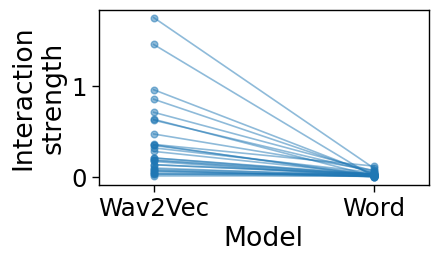

In [349]:
spaghetti_data = interaction_model_fits[interaction_model_fits.model_name.isin(("ffff_32", "id")) &
                                        (interaction_model_fits.base_model_name == "w2v2_8") &
                                        (interaction_model_fits.variable.str.contains(":"))] \
    .pivot_table(index="variable", columns="model_name", values="coef_norm")
# reorder
assert set(spaghetti_data.columns) == {"ffff_32", "id"}
spaghetti_data = spaghetti_data[["id", "ffff_32"]]
spaghetti_data.columns = spaghetti_data.columns.map({"id": "Wav2Vec", main_plot_run[1]: "Word"})
spaghetti_data = np.abs(spaghetti_data)

f, ax = plt.subplots(figsize=(5, 3))
for variable, row in spaghetti_data.iterrows():
    ax.plot(np.arange(len(row)), row, color=sns.color_palette()[0], marker="o", alpha=0.5)
ax.set_xticks(np.arange(len(row)))
ax.set_xticklabels(spaghetti_data.columns)
ax.set_xlim((-0.25, 1.25))
ax.set_xlabel("Model")
ax.set_ylabel("Interaction\nstrength")

f.tight_layout()
f.savefig(f"{output_dir}/interaction_strength_spaghetti.pdf", bbox_inches="tight")

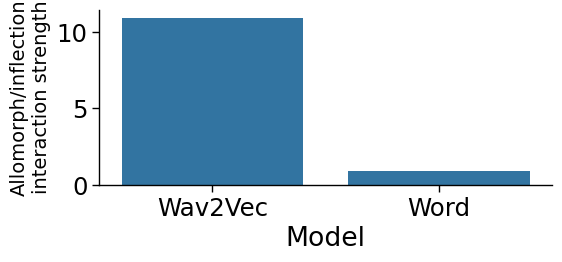

In [287]:
plot_is = interaction_strengths.reindex(plot_runs).reset_index()
plot_is["layer"] = plot_is.base_model_name.str.extract(r"_(\d+)$").astype(int)
plot_is["model_name"] = plot_is["model_name"].map({"id": "Wav2Vec", main_plot_run[1]: "Word"})

g = sns.catplot(data=plot_is[plot_is.layer == 8],
                x="model_name", y="coef_norm", order=["Wav2Vec", "Word"],
                kind="bar", height=3, aspect=2)
g.axes.flat[0].set_ylabel("Allomorph/inflection\ninteraction strength", fontsize=14)
g.axes.flat[0].set_xlabel("Model")

g.tight_layout()
g.savefig(f"{output_dir}/interaction_strength.pdf", bbox_inches="tight")

### Correct for verb paradigm size

In [32]:
# study_df = nnvb_focus[(nnvb_focus.inflection_to == "VBZ")].copy()

In [33]:
# study_df["predicted_stem"] = study_df.predicted_label.str.replace(r"s$|ed$|ings?$", "", regex=True)
# study_df["base_to_stem"] = study_df.base_to.str.replace(r"e$", "", regex=True).replace(r"y$", "i", regex=True)
# study_df["predicted_within_inflection"] = \
#     (study_df.predicted_stem == study_df.base_to) | (study_df.predicted_stem == study_df.base_to_stem)
# vb_irregulars = [("do", "did"), ("do", "does"), ("begin", "began"), ("learn", "learnt"), ("send", "sent"), ("shine", "shone"), ("seem", "seem'd"), ("read", "red"),
#                  ("possess", "possesses"), ("bring", "brings"), ("carry", "carries"), ("occur", "occurred"), ("think", "thinkest"), ("grow", "grew"),
#                  ("put", "putting"), ("begin", "beginning"), ("give", "givest"),
#                  # homophones
#                  ("allow", "aloud"), ("write", "rights"), ("write", "wright's"), ("depend", "dependent")]
# for base, predicted in vb_irregulars:
#     study_df.loc[study_df.base_to == base, "predicted_within_inflection"] |= study_df.loc[study_df.base_to == base].predicted_label == predicted

In [34]:
# merge_keys = ["experiment", "equivalence", "model_label", "model_name", "base_model_name", "group", "inflection_from", "inflection_to", "base_from", "inflected_from", "base_to", "inflected_to"]
# nnvb_focus = pd.merge(nnvb_focus.reset_index(), study_df.reset_index()[merge_keys + ["predicted_within_inflection"]],
#          on=merge_keys, how="left")

In [35]:
# nnvb_focus["correct_or_predicted_within_inflection"] = nnvb_focus.correct | nnvb_focus.predicted_within_inflection

In [36]:
# nnvb_results_summary2 = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to"]) \
#     [["correct_or_predicted_within_inflection", "correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

# nnvb_results_summary2["transfer_label"] = nnvb_results_summary2.inflection_from + " -> " + nnvb_results_summary2.inflection_to
# nnvb_results_summary2

In [37]:
# f, axs = plt.subplots(1, 3, figsize=(4 * 2, 3), gridspec_kw={'width_ratios': [1, 1, 0.04]})

# vmin = 0
# vmax = nnvb_results_summary2.correct_or_predicted_within_inflection.max()

# for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary2.groupby("model_label"))):
#     cbar_ax = None
#     if i == 1:
#         cbar_ax = axs.flat[-1]
    
#     ax.set_title(model_label)
#     sns.heatmap(rows.set_index(["inflection_from", "inflection_to"]).correct_or_predicted_within_inflection.unstack(),
#                 vmin=vmin, vmax=vmax,
#                 annot=True, ax=ax, cbar=i == 1, cbar_ax=cbar_ax)
#     ax.set_xlabel("Test")
#     ax.set_ylabel("Train")

# f = plt.gcf()
# f.tight_layout()
# f.savefig(f"{output_dir}/nnvb_results-correct_inflection.pdf")

In [38]:
# nnvb_plot = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to", "base_to"]).correct_or_predicted_within_inflection.mean().reset_index()
# nnvb_plot["transfer_label"] = nnvb_plot.inflection_from + " -> " + nnvb_plot.inflection_to
# order = ["NNS -> VBZ", "VBZ -> VBZ", "VBZ -> NNS", "NNS -> NNS"]
# g = sns.catplot(data=nnvb_plot, x="transfer_label", y="correct_or_predicted_within_inflection", kind="bar", hue="model_label", order=order, errorbar="se", height=4, aspect=2)
# g._legend.set_title("Model")
# ax = g.axes.flat[0]

# ax.set_xlabel("Evaluation")
# ax.set_ylabel("Accuracy")

### Frequency analysis

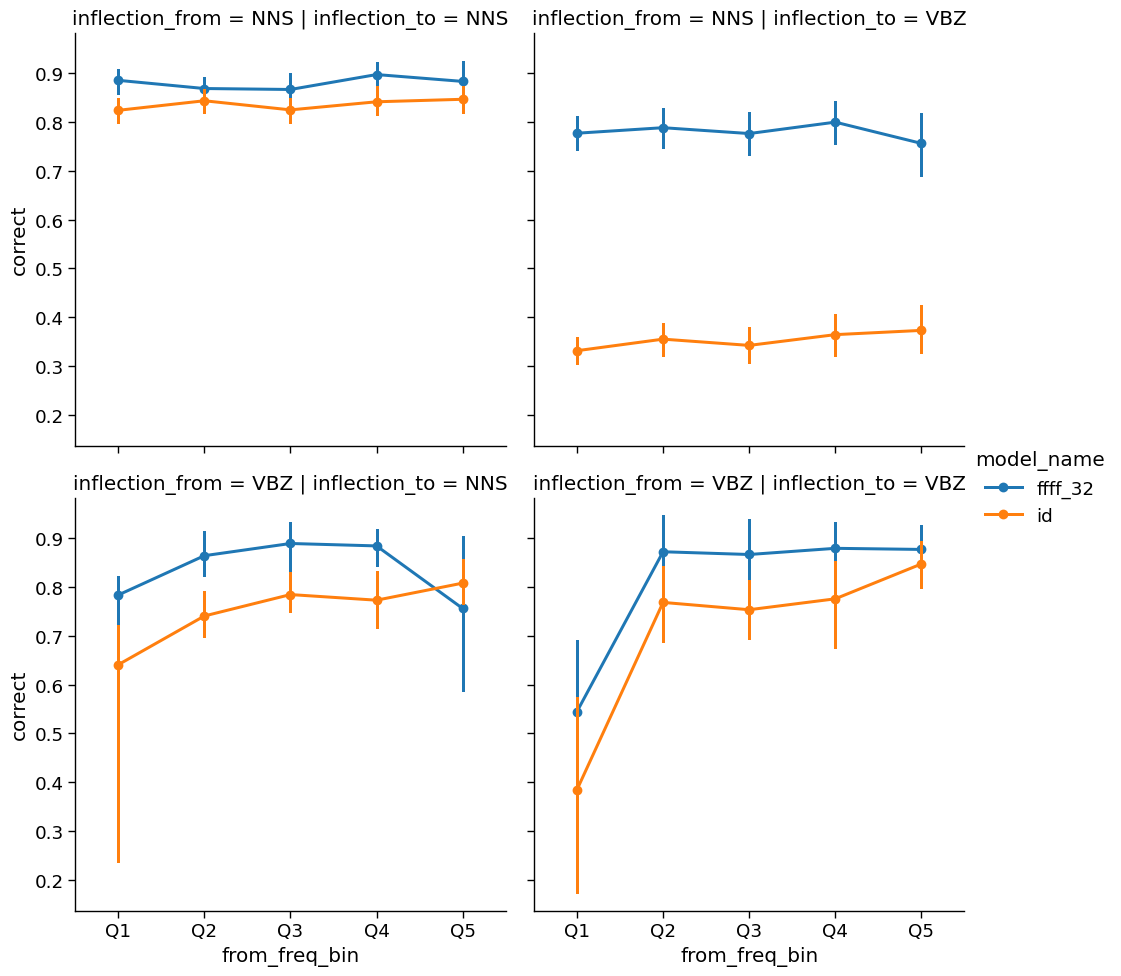

In [39]:
sns.catplot(data=nnvb_focus.reset_index(),
            x="from_freq_bin", y="correct", hue="model_name",
            row="inflection_from", col="inflection_to", units="base_from", kind="point")

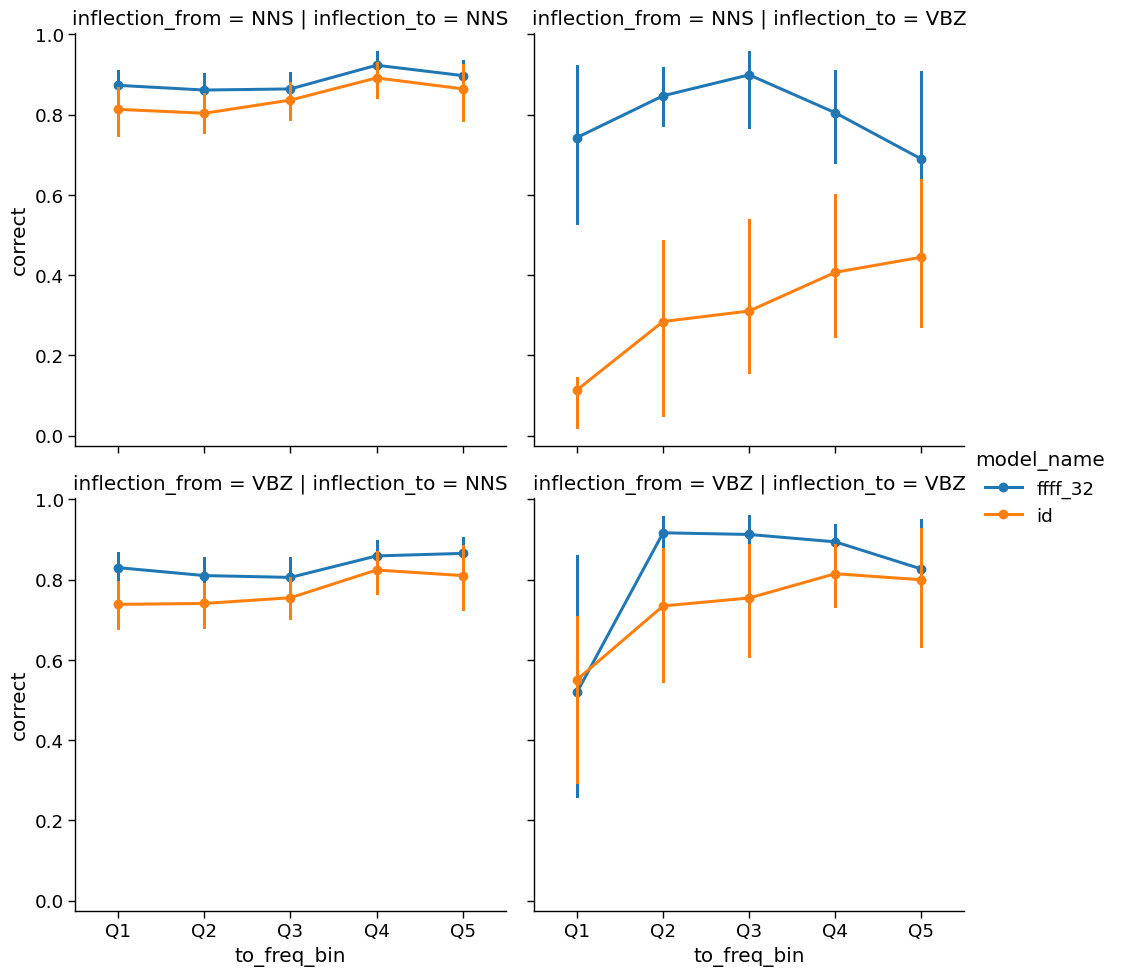

In [40]:
sns.catplot(data=nnvb_focus.reset_index(),
            x="to_freq_bin", y="correct", hue="model_name",
            row="inflection_from", col="inflection_to", units="base_to", kind="point")

#### On rank

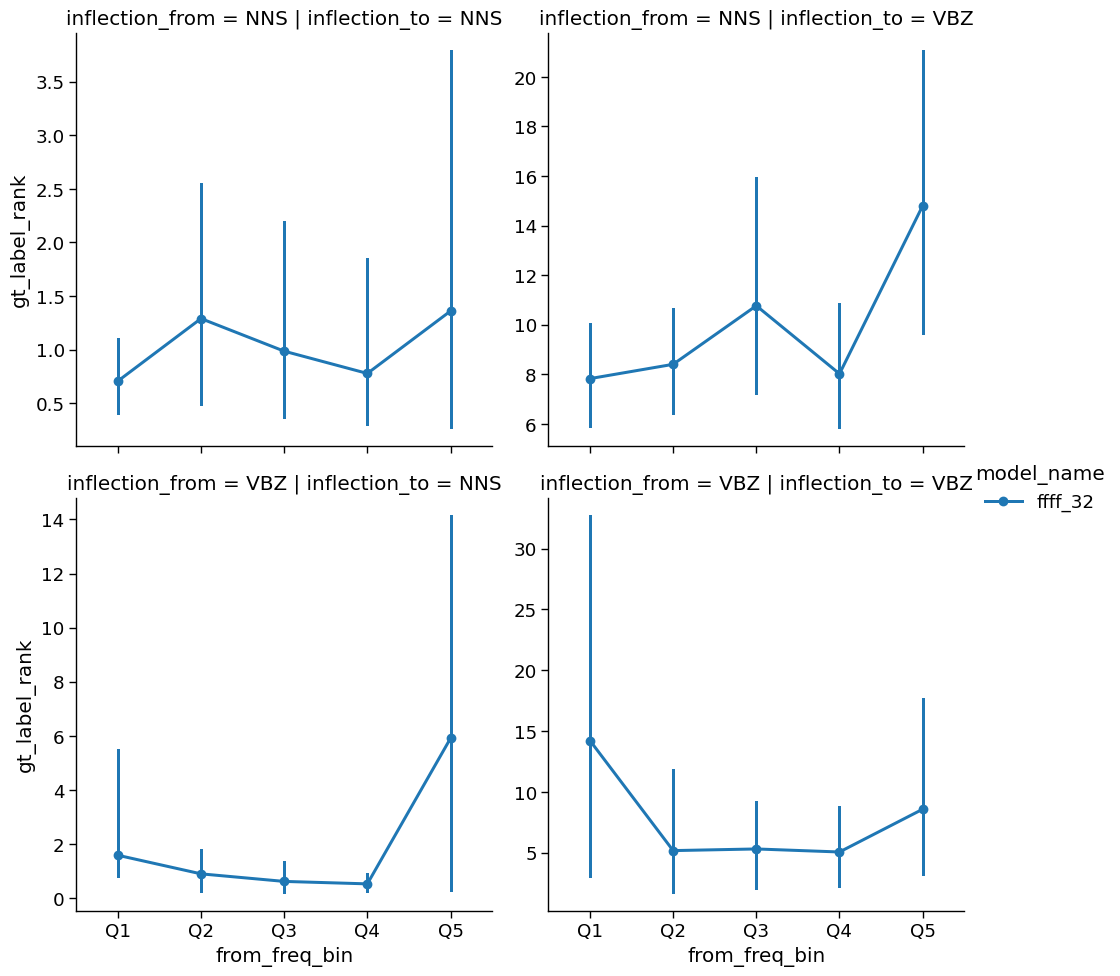

In [41]:
sns.catplot(data=nnvb_focus.reset_index().query("model_name == @focus_model"),
            x="from_freq_bin", y="gt_label_rank", hue="model_name",
            row="inflection_from", col="inflection_to",
            units="base_from", kind="point",
            sharey=False)

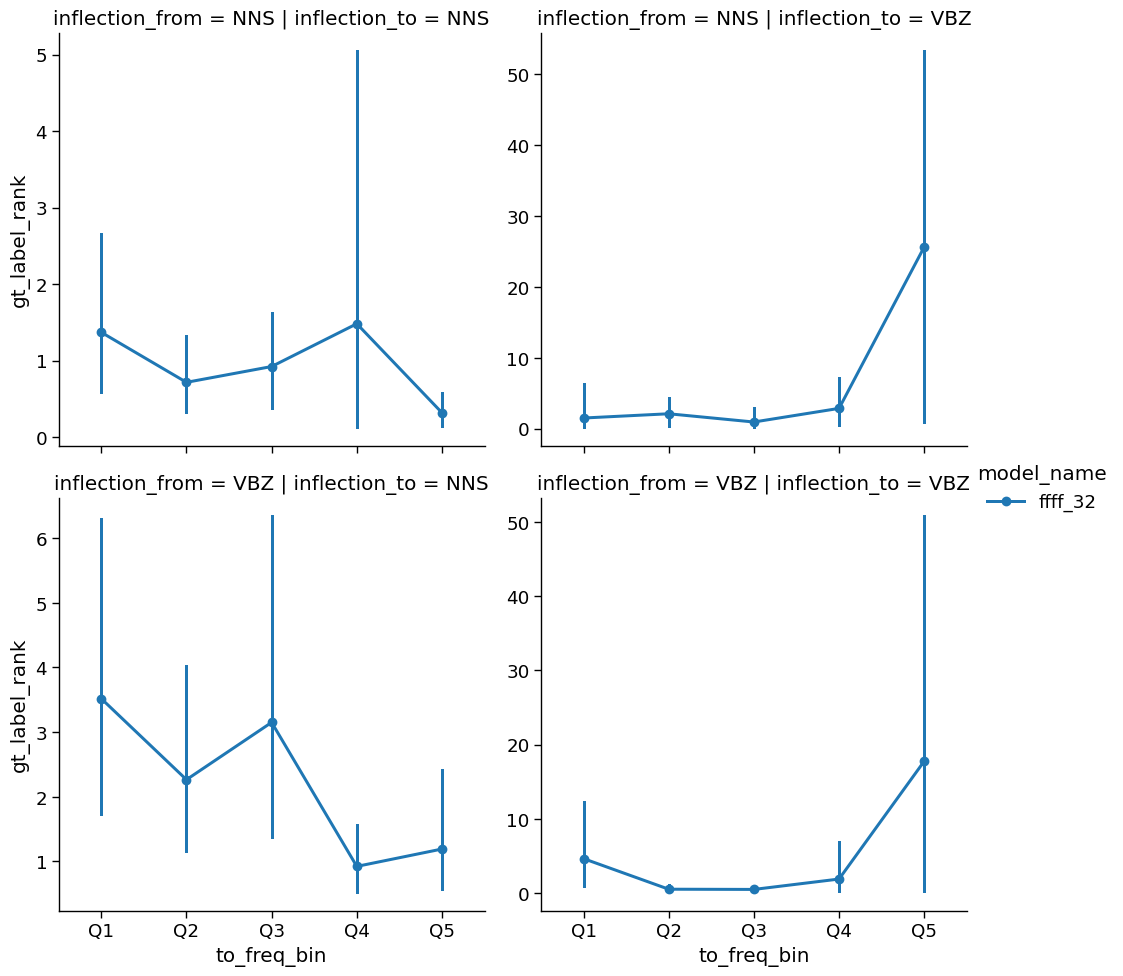

In [42]:
sns.catplot(data=nnvb_focus.reset_index().query("model_name == @focus_model"),
            x="to_freq_bin", y="gt_label_rank", hue="model_name",
            row="inflection_from", col="inflection_to",
            sharey=False,
            units="base_to", kind="point")

## Controlled VBD analysis

In [288]:
all_vbd_results = all_results.query("experiment == 'regular' and inflection_from == 'VBD'")
all_vbd_results = pd.merge(all_vbd_results, most_common_allomorphs.rename(columns={"base": "base_from", "inflection": "inflection_from", "most_common_allomorph": "allomorph_from"}),
               on=["base_from", "inflection_from"], how="left")
all_vbd_results = pd.merge(all_vbd_results, most_common_allomorphs.rename(columns={"base": "base_to", "inflection": "inflection_to", "most_common_allomorph": "allomorph_to"}),
               on=["base_to", "inflection_to"], how="left")
all_vbd_results[["allomorph_from", "allomorph_to"]].value_counts()

allomorph_from  allomorph_to
D               D               11900
T               D                5150
D               IH D             5100
IH D            D                5050
D               T                5000
                                ...  
EH P T          D                  50
                EH L D             50
                EH L T             50
                EY M               50
                AE T               50
Name: count, Length: 748, dtype: int64

In [289]:
# drop do -> did; how did these irregulars get in here?
exclude_vbd_base = ["do", "hide", "make"]
# exclude stress shift items; we don't know which token items have which stress
exclude_vbd_base += "record permit protest reject subject conduct contract conflict increase decrease contest insult impact address escort".split()
# multiple possible
exclude_vbd_base += "dream leap".split()
all_vbd_results = all_vbd_results[~all_vbd_results.base_from.isin(exclude_vbd_base) & ~all_vbd_results.base_to.isin(exclude_vbd_base)]

In [290]:
keep_vbd_allomorphs = all_vbd_results.allomorph_from.value_counts().head(3).index
all_vbd_results = all_vbd_results[all_vbd_results.allomorph_from.isin(keep_vbd_allomorphs)
                                  & all_vbd_results.allomorph_to.isin(keep_vbd_allomorphs)]

In [291]:
# Add frequency information

all_vbd_results["inflected_from"] = all_vbd_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_vbd_results["inflected_to"] = all_vbd_results.to_equiv_label.apply(lambda x: eval(x)[1])

all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("from_base_freq"),
                           left_on="base_from", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("to_base_freq"),
                           left_on="base_to", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

all_vbd_results["from_freq"] = all_vbd_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_vbd_results["to_freq"] = all_vbd_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, vbd_frequency_bins = pd.qcut(pd.concat([all_vbd_results.to_freq, all_vbd_results.from_freq]), q=3, retbins=True)
all_vbd_results["from_freq_bin"] = pd.cut(all_vbd_results.from_freq, bins=vbd_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])
all_vbd_results["to_freq_bin"] = pd.cut(all_vbd_results.to_freq, bins=vbd_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])

In [80]:
def summarize_vbd_run(rows):
    rows["source_label"] = rows.inflection_from + " " + rows.allomorph_from
    rows["target_label"] = rows.inflection_to + " " + rows.allomorph_to

    rows["transfer_label"] = rows.inflection_from + " -> " + rows.inflection_to
    rows["phon_label"] = rows.allomorph_from + " -> " + rows.allomorph_to

    return rows

summary_groupers = ["inflection_from", "inflection_to", "allomorph_from", "allomorph_to"]
vbd_results_summary = all_vbd_results.groupby(run_groupers + summary_groupers) \
    [plot_metrics].mean() \
    .reset_index(summary_groupers) \
    .groupby(run_groupers, group_keys=False) \
    .apply(summarize_vbd_run) \
    .reset_index()

vbd_results_summary

base_model_name              model_name                     equivalence  \
0            w2v2_0           discrim-ff_32  word_broad_10frames_fixedlen25   
1            w2v2_0           discrim-ff_32  word_broad_10frames_fixedlen25   
2            w2v2_0           discrim-ff_32  word_broad_10frames_fixedlen25   
3            w2v2_0           discrim-ff_32  word_broad_10frames_fixedlen25   
4            w2v2_0           discrim-ff_32  word_broad_10frames_fixedlen25   
..              ...                     ...                             ...   
445       w2v2_pc_8  discrim-rnn_32-pc-mAP1  word_broad_10frames_fixedlen25   
446       w2v2_pc_8  discrim-rnn_32-pc-mAP1  word_broad_10frames_fixedlen25   
447       w2v2_pc_8  discrim-rnn_32-pc-mAP1  word_broad_10frames_fixedlen25   
448       w2v2_pc_8  discrim-rnn_32-pc-mAP1  word_broad_10frames_fixedlen25   
449       w2v2_pc_8  discrim-rnn_32-pc-mAP1  word_broad_10frames_fixedlen25   

    inflection_from inflection_to allomorph_from allomorph_to   correct  \
0               VBD           VBD              D            D  0.089362   
1               VBD           VBD              D         IH D  0.031579   
2               VBD           VBD              D            T  0.082474   
3               VBD           VBD           IH D            D  0.074468   
4               VBD           VBD           IH D         IH D  0.060606   
..              ...           ...            ...          ...       ...   
445             VBD           VBD           IH D         IH D  0.545455   
446             VBD           VBD           IH D            T  0.594595   
447             VBD           VBD              T            D  0.600000   
448             VBD           VBD              T         IH D  0.406250   
449             VBD           VBD              T            T  0.555556   

     gt_label_rank  gt_distance source_label target_label transfer_label  \
0       306.208511     0.357088        VBD D        VBD D     VBD -> VBD   
1       622.084211     0.371437        VBD D     VBD IH D     VBD -> VBD   
2       232.278351     0.358383        VBD D        VBD T     VBD -> VBD   
3       353.159574     0.340997     VBD IH D        VBD D     VBD -> VBD   
4       135.818182     0.333413     VBD IH D     VBD IH D     VBD -> VBD   
..             ...          ...          ...          ...            ...   
445       3.636364     1.030057     VBD IH D     VBD IH D     VBD -> VBD   
446       6.081081     0.950876     VBD IH D        VBD T     VBD -> VBD   
447       3.900000     0.933878        VBD T        VBD D     VBD -> VBD   
448       4.625000     0.950576        VBD T     VBD IH D     VBD -> VBD   
449       0.555556     0.896490        VBD T        VBD T     VBD -> VBD   

       phon_label  
0          D -> D  
1       D -> IH D  
2          D -> T  
3       IH D -> D  
4    IH D -> IH D  
..            ...  
445  IH D -> IH D  
446     IH D -> T  
447        T -> D  
448     T -> IH D  
449        T -> T  

[450 rows x 14 columns]

In [81]:
# plot_results = []
# for base_model_name, model_name, equivalence in plot_runs:
#     results_i = vbd_results_summary.query("base_model_name == @base_model_name and model_name == @model_name and equivalence == @equivalence")
#     if len(results_i) > 0:
#         plot_results.append(results_i)
# num_plot_runs = len(plot_results)

# ncols = 4
# nrows = int(np.ceil(num_plot_runs / ncols))
# f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

# for ax, results_i in zip(axs.flat, plot_results):
#     sns.heatmap(results_i.set_index(["source_label", "target_label"]).correct.unstack(),
#                 vmin=0, vmax=1, ax=ax)
#     key_row = results_i.iloc[0]
#     ax.set_title(f"{key_row.base_model_name} -> {key_row.model_name} ({key_row.equivalence})")

In [82]:
vbd_focus = all_vbd_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
vbd_foil = all_vbd_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")
vbd_focus["model_label"] = "Word"
vbd_foil["model_label"] = "Wav2Vec"
vbd_focus = pd.concat([vbd_focus, vbd_foil])

vbd_results_summary2 = vbd_focus.groupby(["model_label", "inflection_from", "inflection_to"]) \
    [plot_metrics].mean().reset_index()

vbd_results_summary2["transfer_label"] = vbd_results_summary2.inflection_from + " -> " + vbd_results_summary2.inflection_to
vbd_results_summary2

/tmp/ipykernel_483784/3386417737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vbd_focus["model_label"] = "Word"
/tmp/ipykernel_483784/3386417737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vbd_foil["model_label"] = "Wav2Vec"


model_label inflection_from inflection_to   correct  gt_label_rank  \
0     Wav2Vec             VBD           VBD  0.717333       6.708000   
1        Word             VBD           VBD  0.830667       2.385333   

   gt_distance transfer_label  
0     0.515659     VBD -> VBD  
1     0.215118     VBD -> VBD

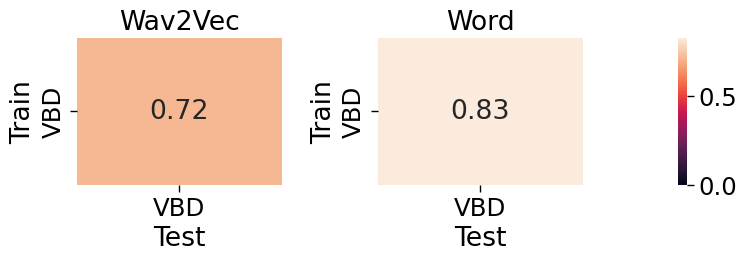

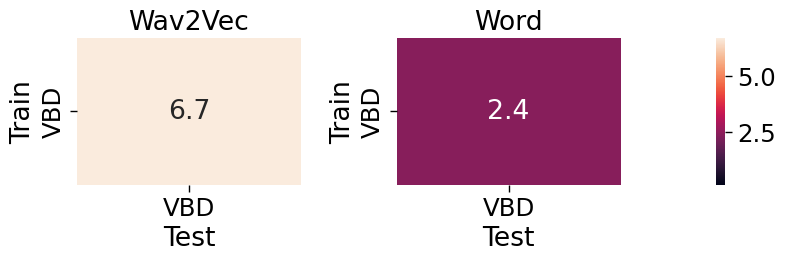

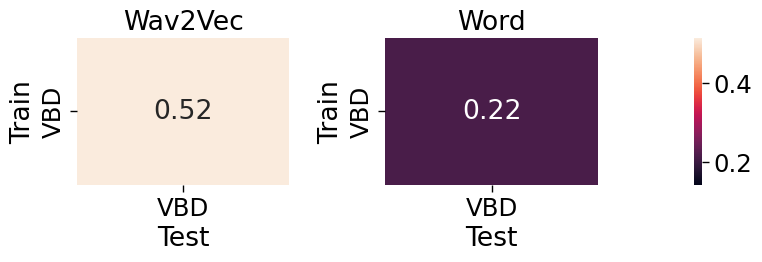

In [83]:
for metric in plot_metrics:
    vmin = 0 if metric == "correct" else nnvb_results_summary[metric].min()
    vmax = vbd_results_summary2[metric].max()

    f, axs = plt.subplots(1, 3, figsize=(4 * 2, 3), gridspec_kw={'width_ratios': [1, 1, 0.04]})

    for i, (ax, (model_label, rows)) in enumerate(zip(axs, vbd_results_summary2.groupby("model_label"))):
        cbar_ax = None
        if i == 1:
            cbar_ax = axs.flat[-1]
        
        ax.set_title(model_label)
        sns.heatmap(rows.set_index(["inflection_from", "inflection_to"])[metric].unstack(),
                    annot=True, vmin=vmin, vmax=vmax, ax=ax,
                    cbar=i == 1, cbar_ax=cbar_ax)
        ax.set_xlabel("Test")
        ax.set_ylabel("Train")

    f = plt.gcf()
    f.tight_layout()
    f.savefig(f"{output_dir}/vbd_results-{metric}.pdf")

### Focused plots

In [84]:
focus_base_model, focus_model, focus_equivalence = main_plot_run
foil_base_model, foil_model, foil_equivalence = "w2v2_8", "id", "id"

vbd_focus = all_vbd_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
vbd_foil = all_vbd_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")
vbd_focus["model_label"] = "Word"
vbd_foil["model_label"] = "Wav2Vec"

vbd_focus = pd.concat([vbd_focus, vbd_foil])

allomorph_labels = {"D": "d", "T": "t", "IH D": "ɪd"}
vbd_focus["allomorph_from"] = vbd_focus.allomorph_from.map(allomorph_labels)
vbd_focus["allomorph_to"] = vbd_focus.allomorph_to.map(allomorph_labels)
vbd_focus

/tmp/ipykernel_483784/2170661113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vbd_focus["model_label"] = "Word"
/tmp/ipykernel_483784/2170661113.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vbd_foil["model_label"] = "Wav2Vec"


index                     equivalence model_name base_model_name  \
56304  2979814  word_broad_10frames_fixedlen25    ffff_32          w2v2_8   
56412  2979922  word_broad_10frames_fixedlen25    ffff_32          w2v2_8   
56570  2980080  word_broad_10frames_fixedlen25    ffff_32          w2v2_8   
56939  2980449  word_broad_10frames_fixedlen25    ffff_32          w2v2_8   
57000  2980510  word_broad_10frames_fixedlen25    ffff_32          w2v2_8   
...        ...                             ...        ...             ...   
93995  4927485                              id         id          w2v2_8   
93996  4927486                              id         id          w2v2_8   
93997  4927487                              id         id          w2v2_8   
93998  4927488                              id         id          w2v2_8   
93999  4927489                              id         id          w2v2_8   

      experiment  Unnamed: 1         group              from_equiv_label  \
56304    regular        2170  (VBD, False)               ('lead', 'led')   
56412    regular        2278  (VBD, False)               ('have', 'had')   
56570    regular        2436  (VBD, False)              ('bend', 'bent')   
56939    regular        2805  (VBD, False)              ('light', 'lit')   
57000    regular        2866   (VBD, True)        ('reckon', 'reckoned')   
...          ...         ...           ...                           ...   
93995    regular        3861   (VBD, True)             ('hope', 'hoped')   
93996    regular        3862   (VBD, True)  ('establish', 'established')   
93997    regular        3863   (VBD, True)      ('neglect', 'neglected')   
93998    regular        3864   (VBD, True)       ('include', 'included')   
93999    regular        3865   (VBD, True)           ('shave', 'shaved')   

                      to_equiv_label  base_from  ... inflected_to  \
56304             ('dwell', 'dwelt')       lead  ...        dwelt   
56412             ('build', 'built')       have  ...        built   
56570               ('send', 'sent')       bend  ...         sent   
56939                ('have', 'had')      light  ...          had   
57000             ('envy', 'envied')     reckon  ...       envied   
...                              ...        ...  ...          ...   
93995          ('assure', 'assured')       hope  ...      assured   
93996            ('smoke', 'smoked')  establish  ...       smoked   
93997         ('exceed', 'exceeded')    neglect  ...     exceeded   
93998  ('experience', 'experienced')    include  ...  experienced   
93999           ('cheer', 'cheered')      shave  ...      cheered   

      from_base_freq to_base_freq  from_inflected_freq to_inflected_freq  \
56304       3.769585     2.232318             3.578256          1.282249   
56412       5.247426     3.513097             4.879203          3.444056   
56570       2.648001     3.738118             2.496198          3.667339   
56939       3.825009     5.247426             2.737929          4.879203   
57000       1.875196     2.452339             1.650708          1.326607   
...              ...          ...                  ...               ...   
93995       4.299479     2.393372             2.902086          2.607424   
93996       2.723676     3.192087             3.005068          2.693423   
93997       2.391758     2.289121             2.375635          2.230652   
93998       3.649665     3.842482             3.465604          3.095561   
93999       2.430979     2.839196             2.278280          2.203922   

       from_freq   to_freq  from_freq_bin  to_freq_bin  model_label  
56304   3.673921  1.757284             Q3           Q1         Word  
56412   5.063315  3.478577             Q3           Q3         Word  
56570   2.572099  3.702729             Q2           Q3         Word  
56939   3.281469  5.063315             Q3           Q3         Word  
57000   1.762952  1.889473             Q1           Q1         Word  
...      

In [85]:
vbd_focus.query("inflection_to == 'VBD' and allomorph_to == 'ɪd'").groupby(["model_name", "base_to"]).gt_label_rank.mean().sort_values().tail(20)

model_name  base_to
ffff_32     tend        10.500000
            comfort     12.000000
id          head        13.000000
ffff_32     defeat      14.500000
id          faint       14.666667
            arrest      15.000000
            strut       16.000000
            part        18.000000
ffff_32     effect      18.000000
id          light       19.000000
ffff_32     light       20.000000
id          boast       23.000000
            mind        23.500000
            sight       34.000000
            tend        39.500000
ffff_32     assault     43.000000
id          assent      65.000000
ffff_32     side        90.500000
id          assault     96.000000
            side       229.500000
Name: gt_label_rank, dtype: float64

In [86]:
vbd_focus.query("inflection_to == 'VBD' and allomorph_to == 't'").groupby(["model_name", "base_to"]).gt_label_rank.mean().sort_values().tail(20)

model_name  base_to 
id          disperse       1.333333
ffff_32     shriek         1.500000
id          perish         1.500000
ffff_32     grip           2.000000
id          build          2.000000
ffff_32     trace          2.000000
            build          2.000000
id          snap           2.200000
            hop            3.000000
            worship        3.000000
ffff_32     balance        5.500000
id          miss           6.000000
            menace         7.000000
            face           7.000000
ffff_32     march          9.666667
id          deck          12.500000
ffff_32     match         15.500000
id          pace          18.000000
            link          18.000000
            tap         2385.000000
Name: gt_label_rank, dtype: float64

In [87]:
vbd_focus.query("inflection_to == 'VBD' and allomorph_to == 'd'").groupby(["model_name", "base_to"]).gt_label_rank.mean().sort_values()

model_name  base_to   
id          change          0.0
            crawl           0.0
            continue        0.0
            consider        0.0
            conjecture      0.0
                          ...  
ffff_32     pile           54.0
            row            81.0
id          decree         88.0
ffff_32     nose          411.0
id          row           619.0
Name: gt_label_rank, Length: 540, dtype: float64

In [88]:
vbd_results_summary = vbd_focus.groupby(["model_label", "inflection_from", "inflection_to",
                                             "allomorph_from", "allomorph_to"]) \
    [plot_metrics].mean() \
    .reset_index()

vbd_results_summary["source_label"] = vbd_results_summary.inflection_from + "\n" + vbd_results_summary.allomorph_from
vbd_results_summary["target_label"] = vbd_results_summary.inflection_to + "\n" + vbd_results_summary.allomorph_to

vbd_results_summary["transfer_label"] = vbd_results_summary.inflection_from + " -> " + vbd_results_summary.inflection_to
vbd_results_summary["phon_label"] = vbd_results_summary.allomorph_from + " " + vbd_results_summary.allomorph_to

# only retain cases where we have data in both transfer directions from source <-> target within inflection
vbd_results_summary["complement_exists"] = vbd_results_summary.apply(lambda row: len(vbd_results_summary.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
vbd_results_summary = vbd_results_summary.query("complement_exists > 0").drop(columns=["complement_exists"])

vbd_results_summary

model_label inflection_from inflection_to allomorph_from allomorph_to  \
0      Wav2Vec             VBD           VBD              d            d   
1      Wav2Vec             VBD           VBD              d            t   
2      Wav2Vec             VBD           VBD              d           ɪd   
3      Wav2Vec             VBD           VBD              t            d   
4      Wav2Vec             VBD           VBD              t            t   
5      Wav2Vec             VBD           VBD              t           ɪd   
6      Wav2Vec             VBD           VBD             ɪd            d   
7      Wav2Vec             VBD           VBD             ɪd            t   
8      Wav2Vec             VBD           VBD             ɪd           ɪd   
9         Word             VBD           VBD              d            d   
10        Word             VBD           VBD              d            t   
11        Word             VBD           VBD              d           ɪd   
12        Word             VBD           VBD              t            d   
13        Word             VBD           VBD              t            t   
14        Word             VBD           VBD              t           ɪd   
15        Word             VBD           VBD             ɪd            d   
16        Word             VBD           VBD             ɪd            t   
17        Word             VBD           VBD             ɪd           ɪd   

     correct  gt_label_rank  gt_distance source_label target_label  \
0   0.748936       3.991489     0.512062       VBD\nd       VBD\nd   
1   0.773196      25.783505     0.526686       VBD\nd       VBD\nt   
2   0.621053       9.094737     0.528517       VBD\nd      VBD\nɪd   
3   0.740000       2.160000     0.507205       VBD\nt       VBD\nd   
4   0.925926       0.074074     0.507479       VBD\nt       VBD\nt   
5   0.531250       6.000000     0.540820       VBD\nt      VBD\nɪd   
6   0.659574       2.255319     0.511782      VBD\nɪd       VBD\nd   
7   0.594595       1.675676     0.514157      VBD\nɪd       VBD\nt   
8   0.848485       1.333333     0.492485      VBD\nɪd      VBD\nɪd   
9   0.863830       2.225532     0.212450       VBD\nd       VBD\nd   
10  0.917526       0.443299     0.215710       VBD\nd       VBD\nt   
11  0.705263       4.252632     0.217460       VBD\nd      VBD\nɪd   
12  0.840000       0.650000     0.201730       VBD\nt       VBD\nd   
13  0.962963       0.074074     0.210092       VBD\nt       VBD\nt   
14  0.718750       1.625000     0.215812       VBD\nt      VBD\nɪd   
15  0.744681       6.691489     0.229527      VBD\nɪd       VBD\nd   
16  0.837838       1.540541     0.246074      VBD\nɪd       VBD\nt   
17  0.909091       0.424242     0.193903      VBD\nɪd      VBD\nɪd   

   transfer_label phon_label  
0      VBD -> VBD        d d  
1      VBD -> VBD        d t  
2      VBD -> VBD       d ɪd  
3      VBD -> VBD        t d  
4      VBD -> VBD        t t  
5      VBD -> VBD       t ɪd  
6      VBD -> VBD       ɪd d  
7      VBD -> VBD       ɪd t  
8      VBD -> VBD      ɪd ɪd  
9      VBD -> VBD        d d  
10     VBD -> VBD        d t  
11     VBD -> VBD       d ɪd  
12     VBD -> VBD        t d  
13     VBD -> VBD        t t  
14     VBD -> VBD       t ɪd  
15     VBD -> VBD       ɪd d  
16     VBD -> VBD       ɪd t  
17     VBD -> VBD      ɪd ɪd

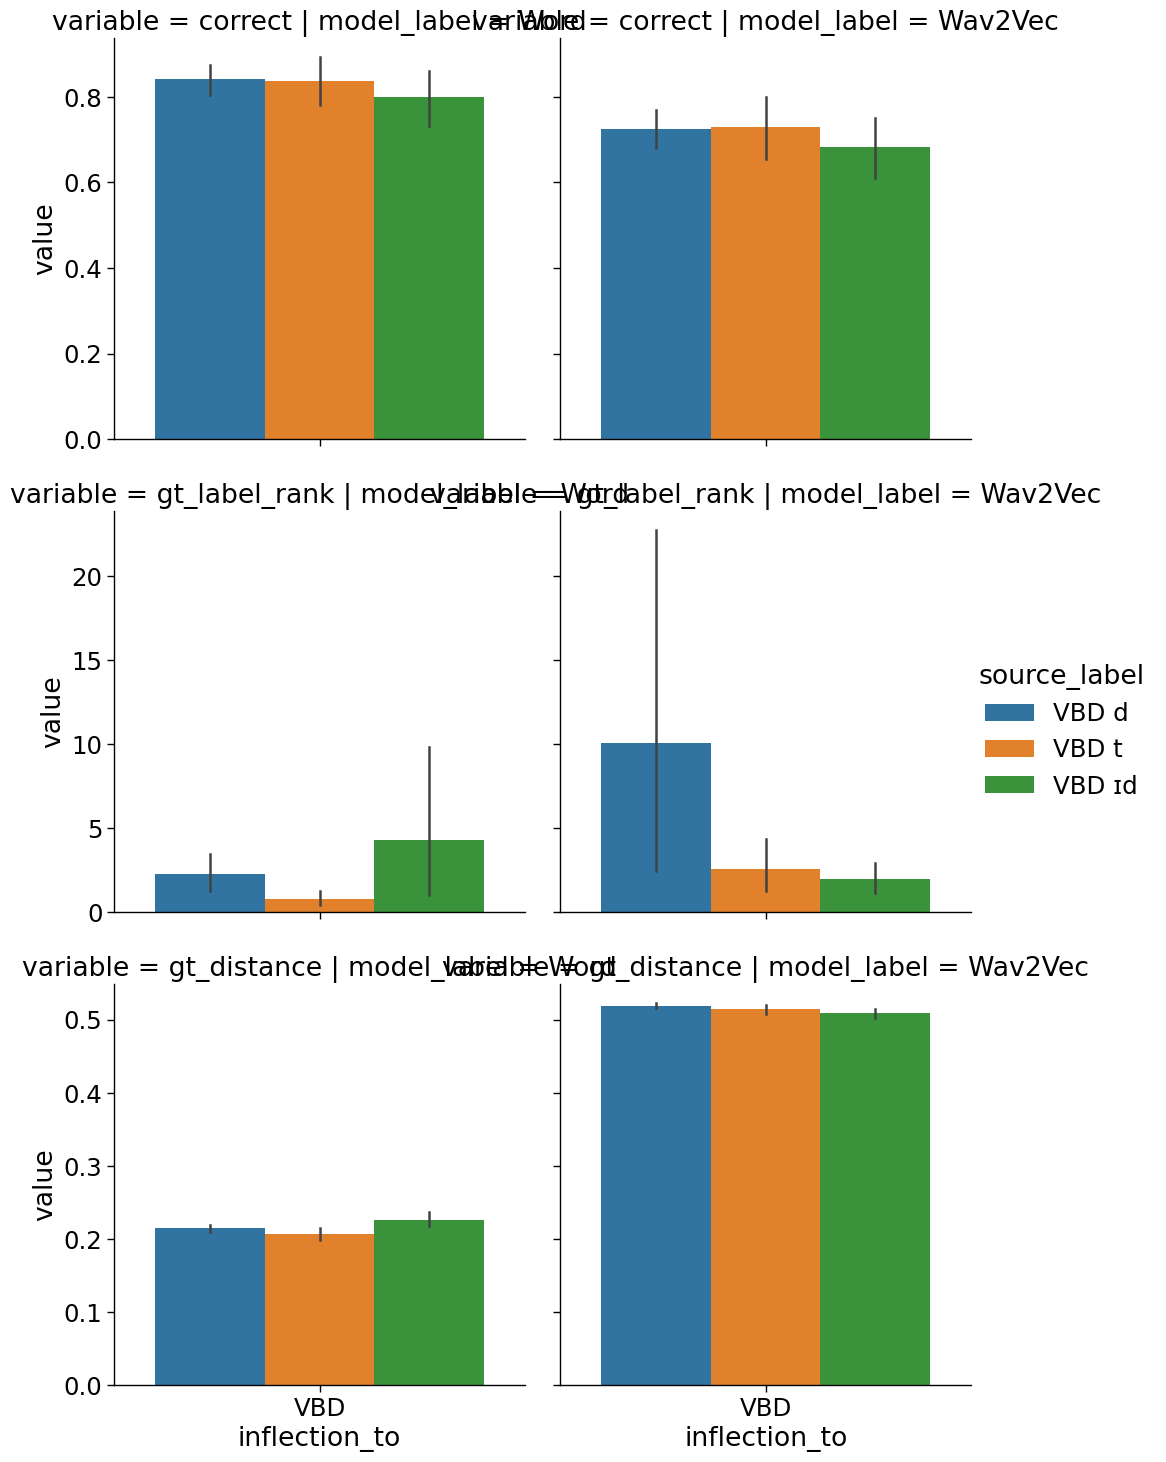

In [89]:
sns.catplot(data=vbd_focus.melt(id_vars=["inflection_from", "allomorph_from", "inflection_to", "model_label"], value_vars=plot_metrics)
                        .assign(source_label=lambda xs: xs.inflection_from + " " + xs.allomorph_from),
                x="inflection_to", hue="source_label", y="value", col="model_label", row="variable", kind="bar", sharey="row")

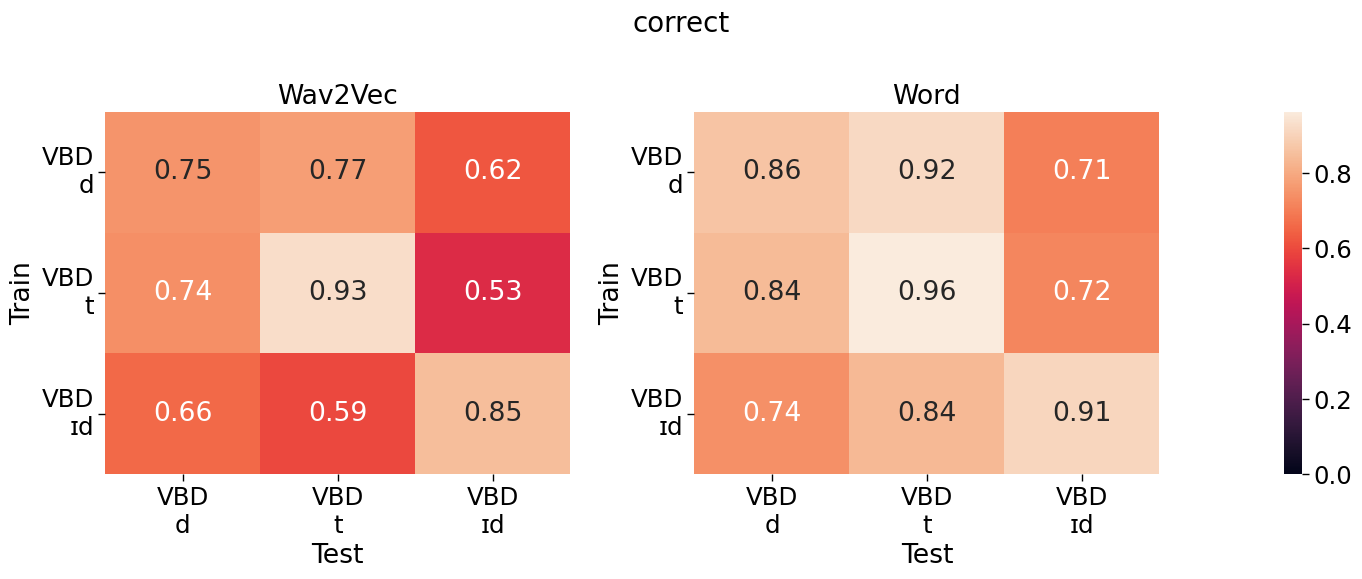

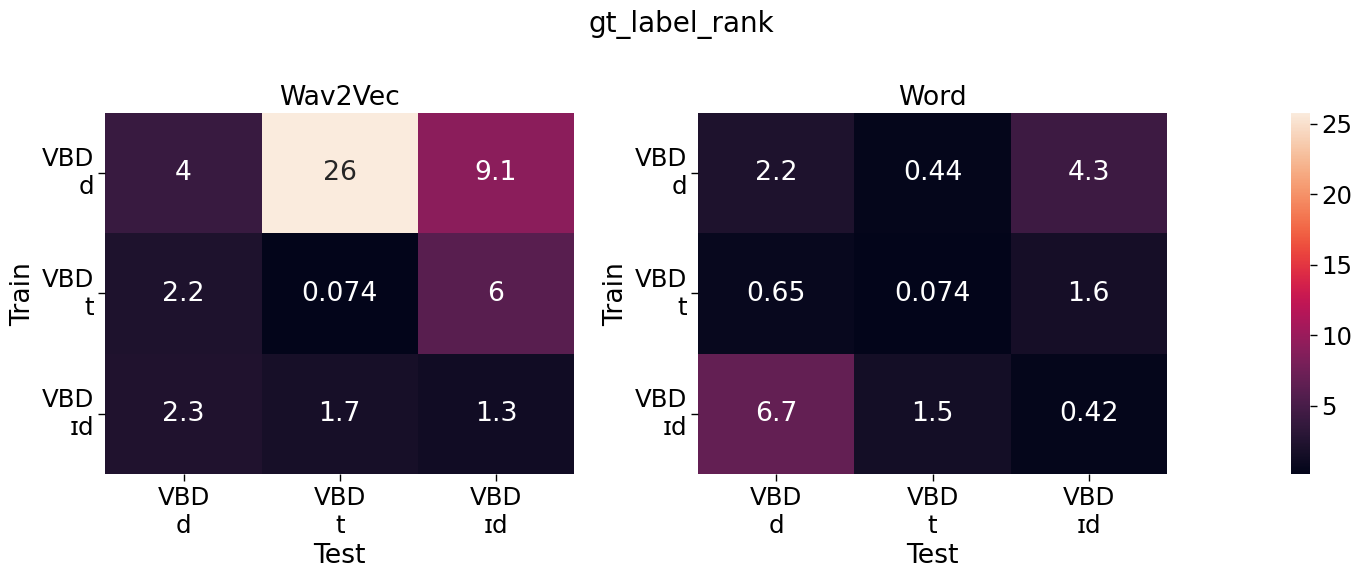

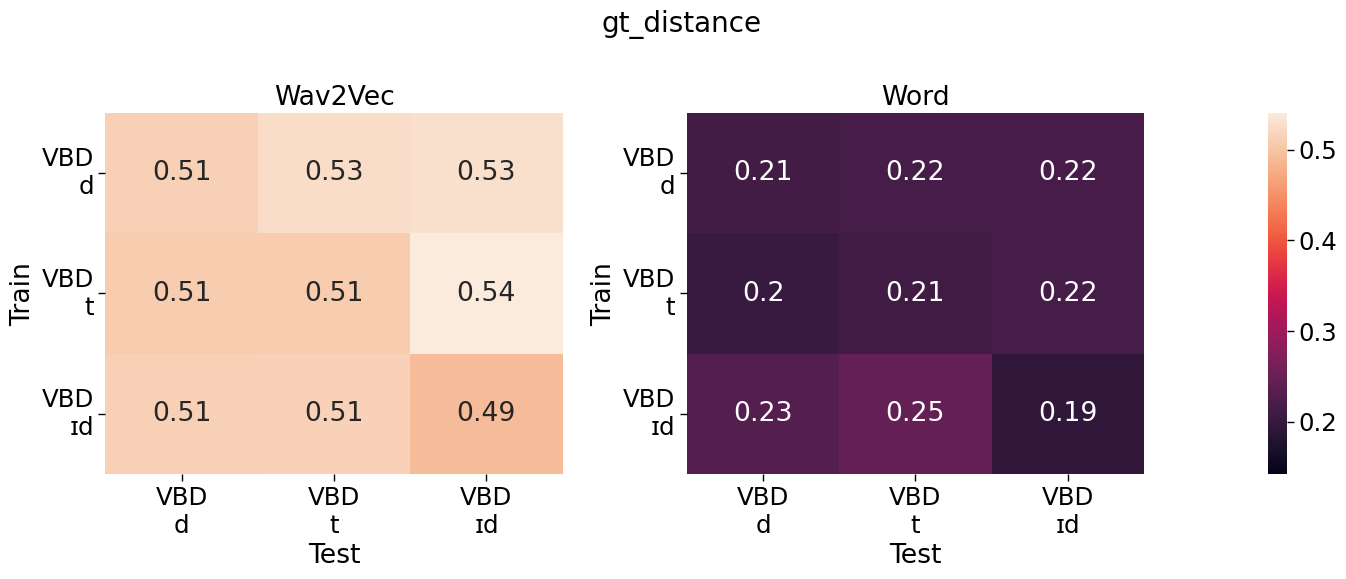

In [90]:
for metric in plot_metrics:
    vmin = 0 if metric == "correct" else nnvb_results_summary[metric].min()
    vmax = vbd_results_summary[metric].max()

    f, axs = plt.subplots(1, 3, figsize=(7 * 2, 6), gridspec_kw={'width_ratios': [1, 1, 0.04]})
    f.suptitle(f"{metric}", fontsize=20)
    for i, (ax, (model_label, rows)) in enumerate(zip(axs, vbd_results_summary.groupby("model_label"))):
        cbar_ax = None
        if i == 1:
            cbar_ax = axs.flat[-1]

        ax.set_title(model_label)
        sns.heatmap(rows.set_index(["source_label", "target_label"]).sort_index()[metric].unstack("target_label"),
                    vmin=vmin, vmax=vmax,
                    annot=True, ax=ax,
                    cbar=i == 1, cbar_ax=cbar_ax)

        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_ylabel("Train")
        ax.set_xlabel("Test")

    f.tight_layout()
    f.savefig(f"{output_dir}/vbd_allomorphs-{metric}.pdf")

### Regression analysis

In [91]:
def get_vbd_interaction_strength(rows):
    rows["correct"] = rows.correct.astype(int)
    
    # exclude rare
    rows = rows[~((rows.inflection_from == "VBZ") & rows.inflection_from == "IH Z") &
                ~((rows.inflection_to == "VBZ") & rows.inflection_to == "IH Z")]
    
    # standardize frequency
    rows["from_freq"] = (rows.from_freq - rows.from_freq.mean()) / rows.from_freq.std()
    rows["to_freq"] = (rows.to_freq - rows.to_freq.mean()) / rows.to_freq.std()
    
    # formula = "correct ~ C(inflection_from, Treatment(reference='NNS')) * C(inflection_to, Treatment(reference='NNS')) + " \
    #           "C(allomorph_from, Treatment(reference='Z')) * C(allomorph_to, Treatment(reference='Z')) +" \
    #           "from_freq + to_freq"
    # model = logit(formula, data=rows).fit()

    formula = "gt_label_rank ~ C(allomorph_from, Treatment(reference='T')) * C(allomorph_to, Treatment(reference='T')) +" \
              "from_freq + to_freq"
    # fit OLS, remove outliers
    model = ols(formula, data=rows[rows.gt_label_rank < np.percentile(rows.gt_label_rank, 90)]).fit()

    return model.params

In [92]:
vbd_interaction_model_fits = all_vbd_results.groupby(run_groupers).apply(get_vbd_interaction_strength) \
    .reset_index().melt(id_vars=run_groupers, value_name="coef_norm")
vbd_interaction_model_fits = vbd_interaction_model_fits[vbd_interaction_model_fits.variable.str.contains(":", regex=True)]
vbd_interaction_model_fits = vbd_interaction_model_fits.groupby(run_groupers).coef_norm.apply(lambda xs: np.linalg.norm(xs, ord=1)).sort_values()

/tmp/ipykernel_483784/470275427.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vbd_interaction_model_fits = all_vbd_results.groupby(run_groupers).apply(get_vbd_interaction_strength) \


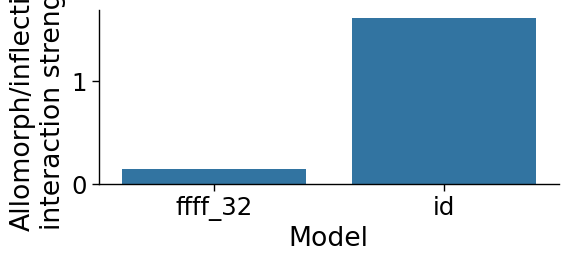

In [93]:
plot_is = vbd_interaction_model_fits.reindex(plot_runs).reset_index()
plot_is["layer"] = plot_is.base_model_name.str.extract(r"_(\d+)$").astype(int)

g = sns.catplot(data=plot_is[plot_is.layer == 8], x="model_name", y="coef_norm", kind="bar", height=3, aspect=2)
g.axes.flat[0].set_ylabel("Allomorph/inflection\ninteraction strength")
g.axes.flat[0].set_xlabel("Model")

g.savefig(f"{output_dir}/vbd_interaction_strength.pdf")

## False friend analysis

In [292]:
all_ff_results = []

for run, run_results in all_results.groupby(run_groupers):
    run_results = run_results.set_index("experiment")
    false_friend_expts = run_results.index.unique()
    false_friend_expts = false_friend_expts[false_friend_expts.str.contains("FF")]

    for expt_name in false_friend_expts:
        expt_df = run_results.loc[expt_name].copy()
        num_seen_words = min(len(expt_df.base_from.unique()), len(expt_df.base_to.unique()))

        if num_seen_words < 10:
            print(f"Skipping {expt} due to only {num_seen_words} seen words")
            continue

        if expt_name.count("-FF-") == 2:
            allomorph_from, allomorph_to = re.findall(r"-FF-([\w\s]+)-to-.+FF-([\w\s]+)", expt_name)[0]
            ff_from, ff_to = True, True
        else:
            try:
                allomorph_from, allomorph_to = re.findall(r"_([\w\s]+)-to-.+FF-([\w\s]+)", expt_name)[0]
                # is the false friend on the "from" side?
                ff_from, ff_to = False, True
            except:
                allomorph_from, allomorph_to = re.findall(r".+FF-([\w\s]+)-to-.+_([\w\s]+)", expt_name)[0]
                ff_from, ff_to = True, False

        expt_df["allomorph_from"] = allomorph_from
        expt_df["allomorph_to"] = allomorph_to

        if ff_from:
            expt_df["inflection_from"] = expt_df.inflection_from.str.replace("-FF-.+", "-FF", regex=True)
        if ff_to:
            expt_df["inflection_to"] = expt_df.inflection_to.str.replace("-FF-.+", "-FF", regex=True)

        expt_df["ff_from"] = ff_from
        expt_df["ff_to"] = ff_to

        all_ff_results.append(expt_df)

    # add within-false-friend tests
    expt_df = run_results.loc["false_friends"].copy()
    expt_df["allomorph_from"] = expt_df.inflection_from.str.extract(r"FF-(.+)$")
    expt_df["allomorph_to"] = expt_df.inflection_to.str.extract(r"FF-(.+)$")
    expt_df["inflection_from"] = expt_df.inflection_from.str.replace("-FF-.+", "-FF", regex=True)
    expt_df["inflection_to"] = expt_df.inflection_to.str.replace("-FF-.+", "-FF", regex=True)
    expt_df["ff_from"] = True
    expt_df["ff_to"] = True

    all_ff_results.append(expt_df)

    # expt_df = expt_df[expt_df.inflection_from.isin(all_ff_results.inflection_from.unique())]

all_ff_results = pd.concat(all_ff_results).reset_index()

ff_exclude = "a b c wreck d e eh wandering lo chiu ha hahn meek jew shew ah co des re san ol der k la ye ll"
ff_exclude_inflected = "bunce los oft mast hauled sward"

# exclude FF bases
all_ff_results = all_ff_results[~(all_ff_results.inflection_from.str.endswith("-FF") & all_ff_results.base_from.isin(ff_exclude.split()))]
all_ff_results = all_ff_results[~(all_ff_results.inflection_to.str.endswith("-FF") & all_ff_results.base_to.isin(ff_exclude.split()))]

all_ff_results["inflected_from"] = all_ff_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_ff_results["inflected_to"] = all_ff_results.to_equiv_label.apply(lambda x: eval(x)[1])

# exclude FF inflected
all_ff_results = all_ff_results[~(all_ff_results.inflection_from.str.endswith("-FF") & all_ff_results.inflected_from.isin(ff_exclude_inflected.split()))]
all_ff_results = all_ff_results[~(all_ff_results.inflection_to.str.endswith("-FF") & all_ff_results.inflected_to.isin(ff_exclude_inflected.split()))]

# add frequency information
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("from_base_freq"), left_on="base_from", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("to_base_freq"), left_on="base_to", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("from_inflected_freq"), left_on="inflected_from", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("to_inflected_freq"), left_on="inflected_to", right_index=True)
all_ff_results["from_freq"] = all_ff_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_ff_results["to_freq"] = all_ff_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

all_ff_results["transfer_label"] = all_ff_results.inflection_from + " -> " + all_ff_results.inflection_to

Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 8 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 8 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 8 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 8 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 8 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 8 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen w

In [293]:
# Post-hoc fix some bugs
all_ff_results.loc[(all_ff_results.base_to == "tho") & (all_ff_results.predicted_label == "though") & (all_ff_results.gt_label_rank == 1), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "philip") & (all_ff_results.predicted_label == "philip's"), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "adam") & (all_ff_results.predicted_label == "adam's"), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "who") & (all_ff_results.predicted_label == "who's"), "correct"] = True

In [294]:
# exclude bad VBD bases
print("before filtering: ", len(all_ff_results))
all_ff_results = all_ff_results[~(((all_ff_results.inflection_to == "VBD") & all_ff_results.base_to.isin(exclude_vbd_base)) |
                                  ((all_ff_results.inflection_from == "VBD") & all_ff_results.base_from.isin(exclude_vbd_base)))]
print("after filtering: ", len(all_ff_results))

before filtering:  1232101
after filtering:  1225573


In [297]:
false_friend_strong_lookup = false_friends_df.set_index(["base", "inflected", "post_divergence"]).strong.to_dict()

In [298]:
def get_is_strong(rows):
    keys = []
    row = rows.iloc[0]
    if "-FF" in row.inflection_from:
        keys.append((row.base_from, row.inflected_from, row.allomorph_from))
    if "-FF" in row.inflection_to:
        keys.append((row.base_to, row.inflected_to, row.allomorph_to))

    # print(keys)
    strong_results = [false_friend_strong_lookup[base, inflected, allomorph] for base, inflected, allomorph in keys]
    return all(strong_results)

strong_grouper = ["inflection_from", "inflection_to", "inflected_from", "inflected_to", "base_from", "base_to", "allomorph_from", "allomorph_to"]
strong_values = all_ff_results.groupby(strong_grouper).apply(get_is_strong).rename("is_strong")
all_ff_results = pd.merge(all_ff_results, strong_values, left_on=strong_grouper, right_index=True)

/tmp/ipykernel_483784/500092804.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strong_values = all_ff_results.groupby(strong_grouper).apply(get_is_strong).rename("is_strong")


In [299]:
weak_ff_results = all_ff_results[~all_ff_results.is_strong]

# ONLY STRONG
all_ff_results = all_ff_results[all_ff_results.is_strong]

In [300]:
all_ff_results.query("inflection_from == 'VBD-FF' & inflection_to == 'VBD' and model_name == 'ffff_32' and base_model_name == 'w2v2_8'") \
    .groupby("base_to").gt_label_rank.mean().sort_values().tail(20)

base_to
issue        735.000000
lack         741.666667
hop          786.500000
command      893.000000
assault     1038.000000
doubt       1115.500000
frown       1440.000000
perch       1673.000000
punish      1680.000000
chase       1763.000000
shelter     1983.000000
glow        2039.250000
hail        2778.000000
vow         2925.000000
peep        3219.000000
block       3681.000000
chance      3726.750000
clutch      4252.833333
circle      4464.666667
peer       39113.000000
Name: gt_label_rank, dtype: float64

### Main FF analysis

In [301]:
ff_frequency_bins = pd.qcut(pd.concat([all_ff_results.to_freq, all_ff_results.from_freq]), q=3, retbins=True)[1]
all_ff_results["from_freq_bin"] = pd.cut(all_ff_results.from_freq, bins=ff_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])
all_ff_results["to_freq_bin"] = pd.cut(all_ff_results.to_freq, bins=ff_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])

In [302]:
# Compare distribution of false friend word frequencies to distribution of NN/VB frequencies.
# This is to see if the false friends are more likely to be rare words.
false_friend_words = pd.concat([all_ff_results.query("ff_from").base_from, all_ff_results.query("ff_to").base_to]).unique()
nn_words = pd.concat([all_nnvb_results.query("inflection_from == 'NNS'").base_from,
                        all_nnvb_results.query("inflection_to == 'NNS'").base_to]).unique()
vb_words = pd.concat([all_nnvb_results.query("inflection_from == 'VBZ'").base_from,
                        all_nnvb_results.query("inflection_to == 'VBZ'").base_to]).unique()

In [303]:
expt_word_freqs = pd.concat({
    "false_friends": word_freq_df.loc[false_friend_words].LogFreq,
    "NN": word_freq_df.loc[nn_words].LogFreq,
    "VB": word_freq_df.loc[vb_words].LogFreq
}, names=["type"])

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

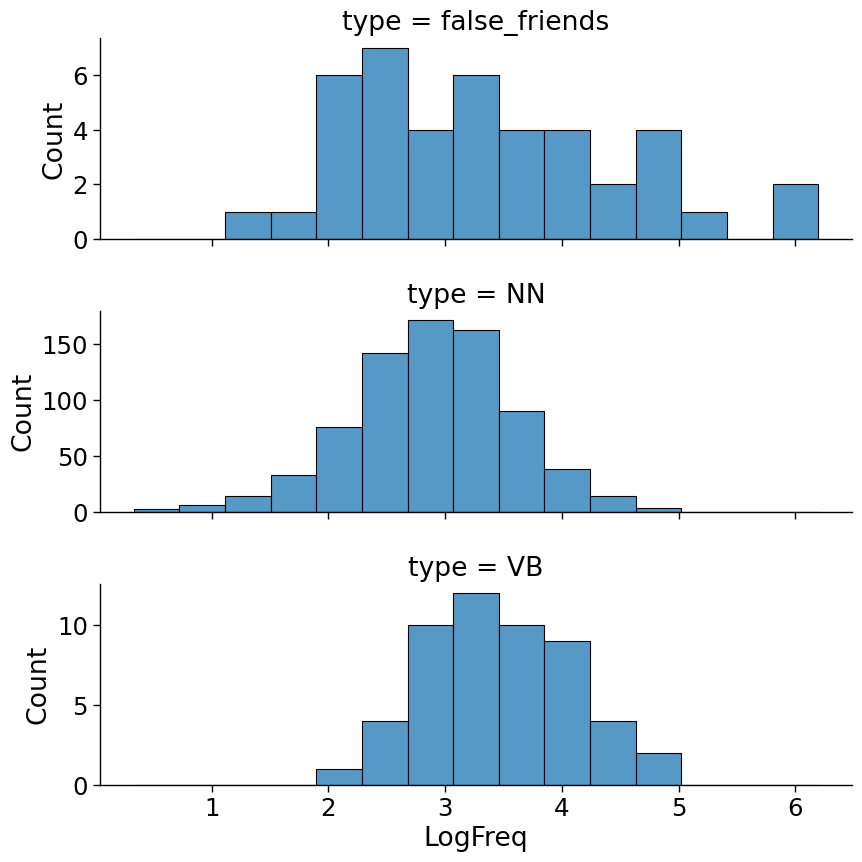

In [304]:
sns.displot(data=expt_word_freqs.reset_index(), x="LogFreq", row="type", kind="hist", bins=15,
            height=3, aspect=3, facet_kws={"sharey": False})

In [305]:
focus_ff_results = all_ff_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
foil_ff_results = all_ff_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")

In [370]:
ff_results_summary2 = pd.concat([focus_ff_results, foil_ff_results]).groupby(["model_name", "inflection_from", "inflection_to"]) \
    [plot_metrics].mean().reset_index()
ff_results_summary2["transfer_label"] = ff_results_summary2.inflection_from + " -> " + ff_results_summary2.inflection_to
assert set(ff_results_summary2.model_name) == {"ffff_32", "id"}
ff_results_summary2["model_label"] = ff_results_summary2["model_name"].map({"id": "Wav2Vec", "ffff_32": "Word"})
ff_results_summary2 = ff_results_summary2.drop(columns=["model_name"])

ff_results_summary2 = pd.concat([ff_results_summary2,
    nnvb_results_summary2.query("inflection_from == inflection_to"),
    vbd_results_summary2.query("inflection_from == inflection_to")])

ff_results_summary2["base_inflection"] = ff_results_summary2.inflection_from.str.replace("-FF", "")
ff_results_summary2 = ff_results_summary2[ff_results_summary2.base_inflection.isin(plot_inflections)]

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


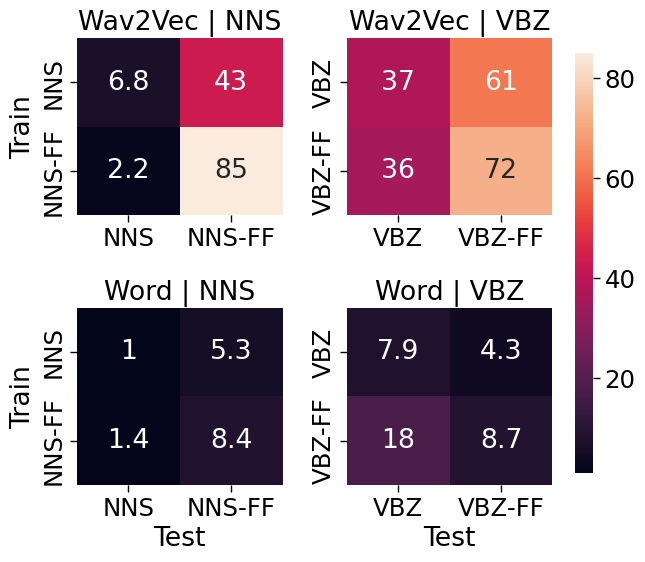

In [373]:
g = sns.FacetGrid(data=ff_results_summary2, row="model_label", col="base_inflection",
                  row_order=["Wav2Vec", "Word"], sharex=False, sharey=False)
plot_variable = "gt_label_rank"

vmin = ff_results_summary2[plot_variable].min()
vmax = ff_results_summary2[plot_variable].max()

def mapfn(data, **kwargs):
    ax = plt.gca()
    sns.heatmap(data.set_index(["inflection_from", "inflection_to"])[plot_variable].unstack("inflection_to"),
                vmin=vmin, vmax=vmax, annot=True, fmt=".2g", ax=ax, cbar=False)

g.map_dataframe(mapfn)

for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        ax.set_title(ax.get_title().replace("base_inflection = ", "").replace("model_label = ", ""))
        if j > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Train")
        
        if i < len(g.axes) - 1:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Test")

# add colorbar
cbar_ax = g.fig.add_axes([0.99, 0.18, 0.03, 0.7])
cbar = plt.colorbar(g.axes.flat[0].collections[0], cax=cbar_ax)
cbar.outline.set_visible(False)

g.tight_layout()
g.savefig(f"{output_dir}/ff_results-merged.pdf", bbox_inches="tight")

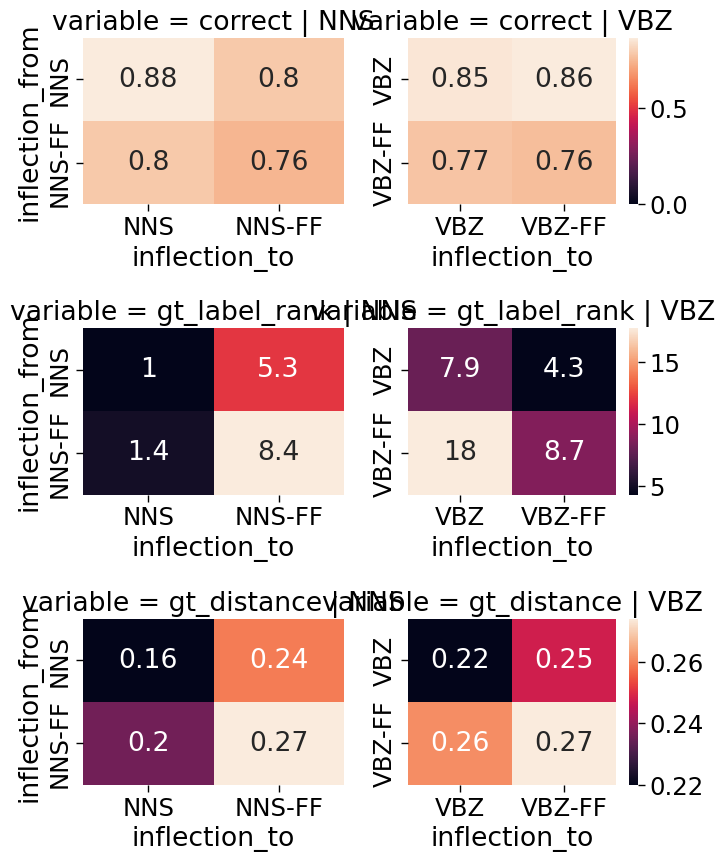

In [309]:
ff_results_summary2 = focus_ff_results.groupby(["inflection_from", "inflection_to"]) \
    [plot_metrics].mean().reset_index()

ff_results_summary2["transfer_label"] = ff_results_summary2.inflection_from + " -> " + ff_results_summary2.inflection_to

# add in data for NNS->NNS and VBZ->VBZ
ff_results_summary2 = pd.concat([
    ff_results_summary2,
    nnvb_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'"),
    vbd_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'")], axis=0)

ff_results_summary2["base_inflection"] = ff_results_summary2.inflection_from.str.replace("-FF", "")
ff_results_summary2 = ff_results_summary2[ff_results_summary2.base_inflection.isin(plot_inflections)]

# g = sns.FacetGrid(ff_results_summary2, col="base_inflection", sharex=False, sharey=False)
g = sns.FacetGrid(data=ff_results_summary2.melt(id_vars=["inflection_from", "inflection_to", "transfer_label", "base_inflection"],
                                                value_vars=plot_metrics),
                    col="base_inflection", row="variable", sharex=False, sharey=False,
                    height=3, aspect=1.25)

def mapfn(data, **kwargs):
    ax = plt.gca()
    metric = data.variable.iloc[0]
    vmin = 0 if metric == "correct" else data.value.min()
    vmax = data.value.max()

    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).value.unstack("inflection_to"),
                vmin=vmin, vmax=vmax, annot=True, ax=ax)

g.map_dataframe(mapfn)

for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        ax.set_title(ax.get_title().replace("base_inflection = ", ""))
        if j > 0:
            ax.set_ylabel("")
        if j < len(row) - 1:
            ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/ff_results.pdf")

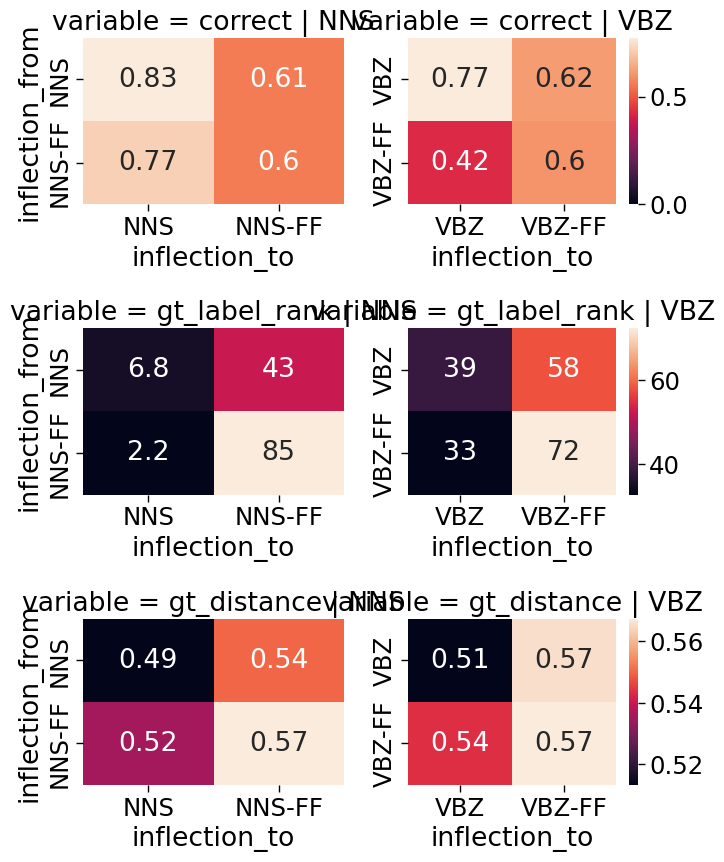

In [156]:
ff_foil_results_summary2 = foil_ff_results.groupby(["inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

ff_foil_results_summary2["transfer_label"] = ff_foil_results_summary2.inflection_from + " -> " + ff_foil_results_summary2.inflection_to

# add in data for NNS->NNS and VBZ->VBZ
ff_foil_results_summary2 = pd.concat([
    ff_foil_results_summary2,
    nnvb_results_summary2.query("inflection_from == inflection_to and model_label == 'Wav2Vec'"),
    vbd_results_summary2.query("inflection_from == inflection_to and model_label == 'Wav2Vec'")], axis=0)

ff_foil_results_summary2["base_inflection"] = ff_foil_results_summary2.inflection_from.str.replace("-FF", "")

ff_foil_results_summary2 = ff_foil_results_summary2[ff_foil_results_summary2.base_inflection.isin(plot_inflections)]

g = sns.FacetGrid(data=ff_foil_results_summary2.melt(id_vars=["inflection_from", "inflection_to", "transfer_label", "base_inflection"],
                                                value_vars=plot_metrics),
                    col="base_inflection", row="variable", sharex=False, sharey=False,
                    height=3, aspect=1.25)
def mapfn(data, **kwargs):
    ax = plt.gca()
    metric = data.variable.iloc[0]
    vmin = 0 if metric == "correct" else data.value.min()
    vmax = data.value.max()

    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).value.unstack("inflection_to"),
                vmin=vmin, vmax=vmax, annot=True, ax=ax)
g.map_dataframe(mapfn)

for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        ax.set_title(ax.get_title().replace("base_inflection = ", ""))
        if j > 0:
            ax.set_ylabel("")
        if j < len(row) - 1:
            ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/ff_results-foil.pdf")

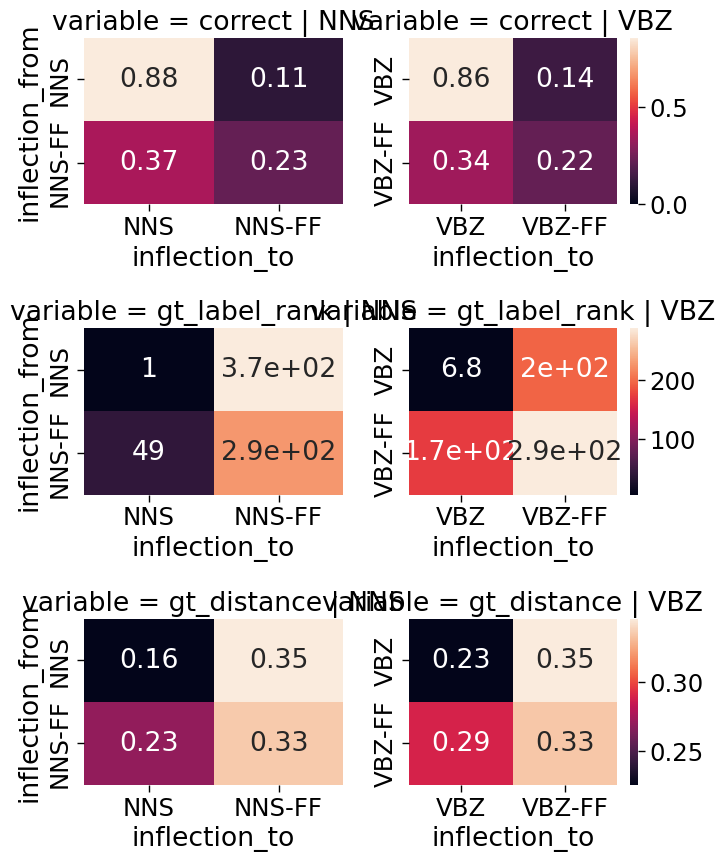

In [157]:
focus_weak_ff_results = weak_ff_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")

weak_ff_results_summary2 = focus_weak_ff_results.groupby(["inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

weak_ff_results_summary2["transfer_label"] = weak_ff_results_summary2.inflection_from + " -> " + weak_ff_results_summary2.inflection_to

# add in data for NNS->NNS and VBZ->VBZ
weak_ff_results_summary2 = pd.concat([weak_ff_results_summary2, nnvb_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'")], axis=0)
# add in data for VBD->VBD
weak_ff_results_summary2 = pd.concat([weak_ff_results_summary2, vbd_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'")], axis=0)

weak_ff_results_summary2["base_inflection"] = weak_ff_results_summary2.inflection_from.str.replace("-FF", "")

weak_ff_results_summary2 = weak_ff_results_summary2[weak_ff_results_summary2.base_inflection.isin(plot_inflections)]

g = sns.FacetGrid(data=weak_ff_results_summary2.melt(id_vars=["inflection_from", "inflection_to", "transfer_label", "base_inflection"],
                                                value_vars=plot_metrics),
                    col="base_inflection", row="variable", sharex=False, sharey=False,
                    height=3, aspect=1.25)
def mapfn(data, **kwargs):
    ax = plt.gca()
    metric = data.variable.iloc[0]
    vmin = 0 if metric == "correct" else data.value.min()
    vmax = data.value.max()

    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).value.unstack("inflection_to"),
                vmin=vmin, vmax=vmax, annot=True, ax=ax)
    
g.map_dataframe(mapfn)

for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        ax.set_title(ax.get_title().replace("base_inflection = ", ""))
        if j > 0:
            ax.set_ylabel("")
        if j < len(row) - 1:
            ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/ff_results_weak.pdf")

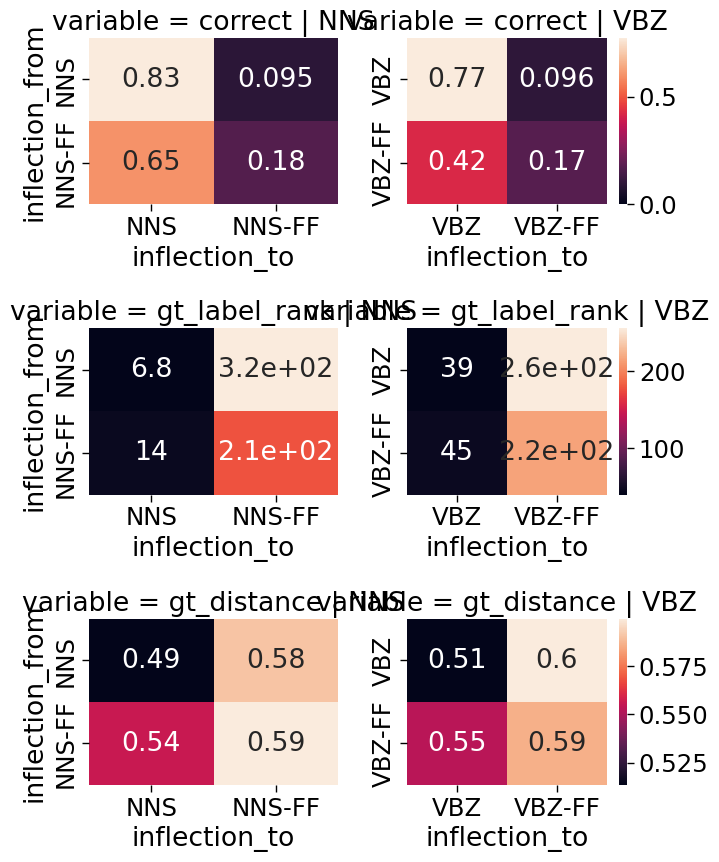

In [158]:
foil_weak_ff_results = weak_ff_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")

weak_ff_foil_results_summary2 = foil_weak_ff_results.groupby(["inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

weak_ff_foil_results_summary2["transfer_label"] = weak_ff_foil_results_summary2.inflection_from + " -> " + weak_ff_foil_results_summary2.inflection_to

# add in data for NNS->NNS and VBZ->VBZ
weak_ff_foil_results_summary2 = pd.concat([weak_ff_foil_results_summary2, nnvb_results_summary2.query("inflection_from == inflection_to and model_label == 'Wav2Vec'")], axis=0)
# add in data for VBD->VBD
weak_ff_foil_results_summary2 = pd.concat([weak_ff_foil_results_summary2, vbd_results_summary2.query("inflection_from == inflection_to and model_label == 'Wav2Vec'")], axis=0)

weak_ff_foil_results_summary2["base_inflection"] = weak_ff_foil_results_summary2.inflection_from.str.replace("-FF", "")

weak_ff_foil_results_summary2 = weak_ff_foil_results_summary2[weak_ff_foil_results_summary2.base_inflection.isin(plot_inflections)]

g = sns.FacetGrid(data=weak_ff_foil_results_summary2.melt(id_vars=["inflection_from", "inflection_to", "transfer_label", "base_inflection"],
                                                value_vars=plot_metrics),
                    col="base_inflection", row="variable", sharex=False, sharey=False,
                    height=3, aspect=1.25)
def mapfn(data, **kwargs):
    ax = plt.gca()
    metric = data.variable.iloc[0]
    vmin = 0 if metric == "correct" else data.value.min()
    vmax = data.value.max()

    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).value.unstack("inflection_to"),
                vmin=vmin, vmax=vmax, annot=True, ax=ax)
    
g.map_dataframe(mapfn)
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        ax.set_title(ax.get_title().replace("base_inflection = ", ""))
        if j > 0:
            ax.set_ylabel("")
        if j < len(row) - 1:
            ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/ff_results_weak-foil.pdf")

### Frequency analysis

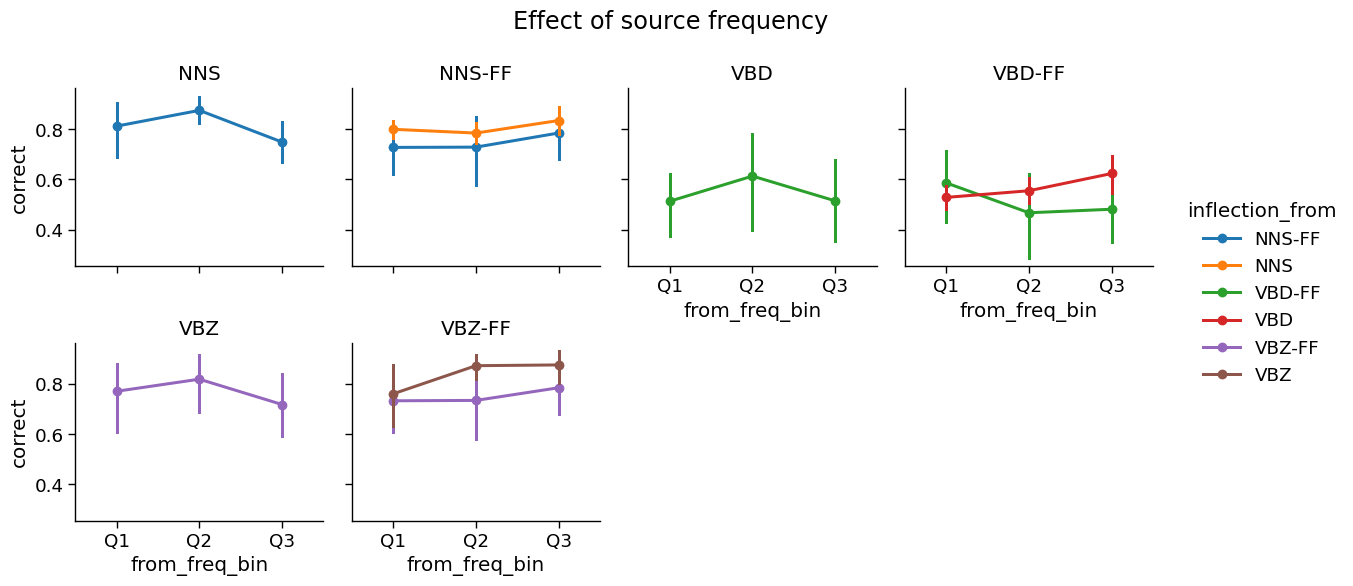

In [101]:
g = sns.catplot(data=focus_ff_results,
            x="from_freq_bin", y="correct", hue="inflection_from",
            col="inflection_to", col_wrap=4, units="base_from", kind="point", height=3)
g.figure.suptitle("Effect of source frequency")
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split("=")[1].strip())
g.tight_layout()

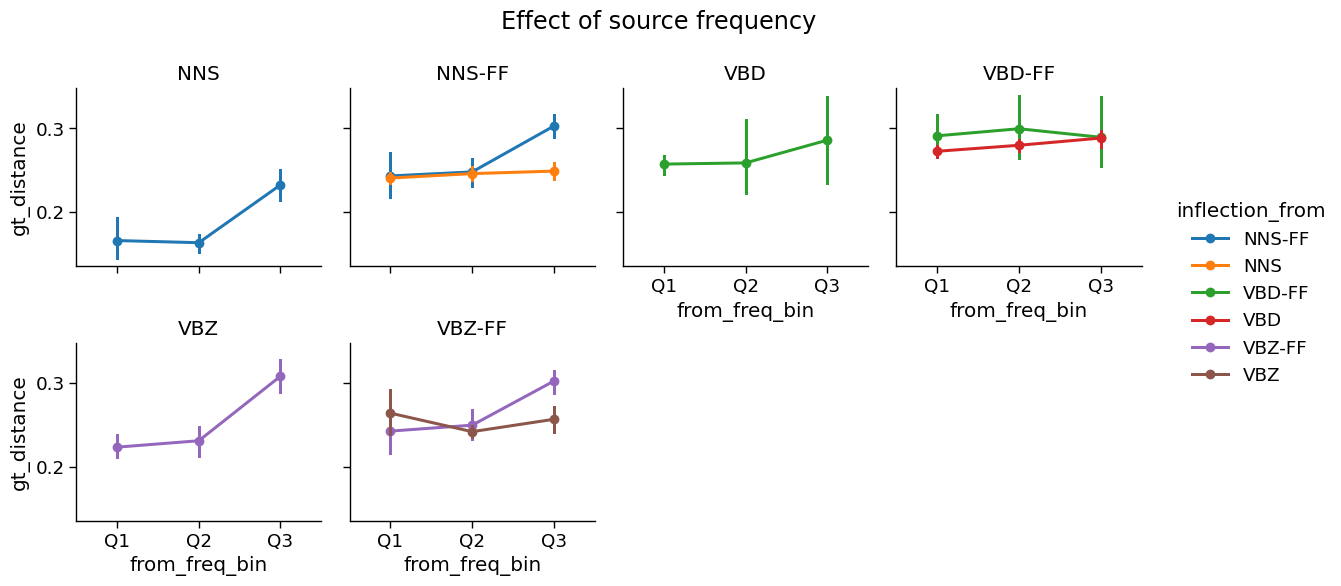

In [102]:
g = sns.catplot(data=focus_ff_results,
            x="from_freq_bin", y="gt_distance", hue="inflection_from",
            col="inflection_to", col_wrap=4, units="base_from", kind="point", height=3)
g.figure.suptitle("Effect of source frequency")
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split("=")[1].strip())
g.tight_layout()

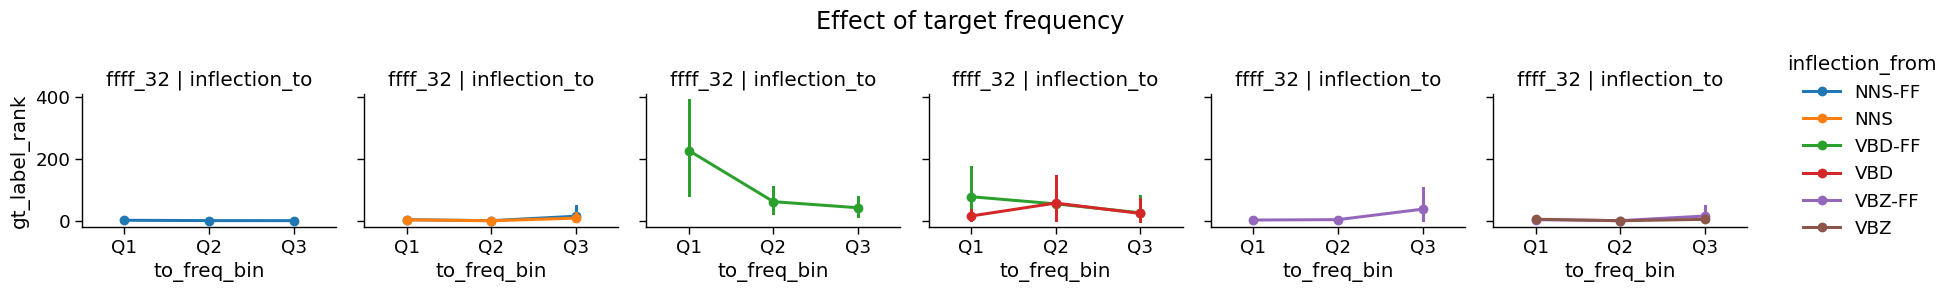

In [233]:
g = sns.catplot(data=focus_ff_results,
            x="to_freq_bin", y="gt_label_rank", hue="inflection_from",
            col="inflection_to", row="model_name", units="base_to", kind="point", height=3)
g.figure.suptitle("Effect of target frequency")
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split("=")[1].strip())
g.tight_layout()

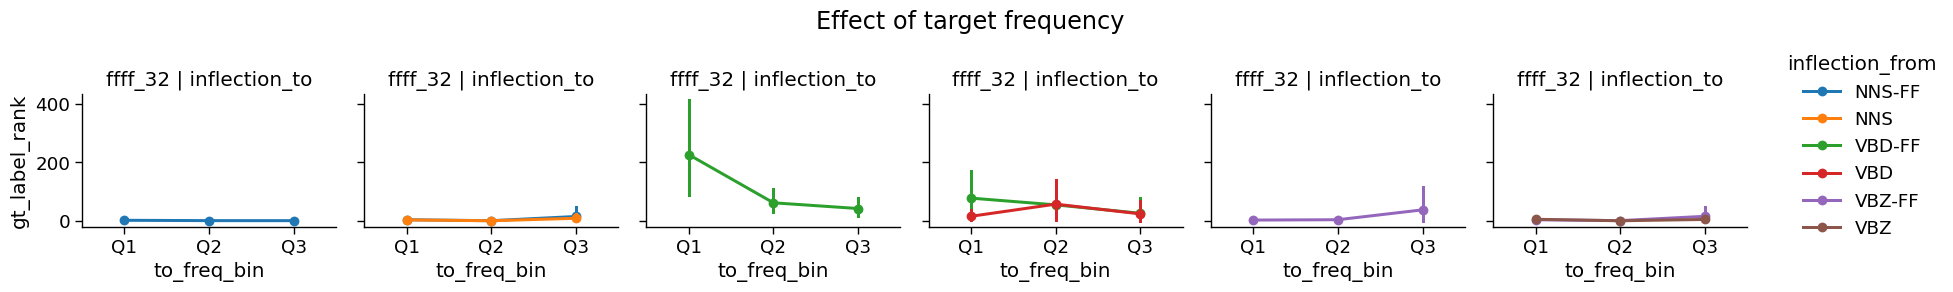

In [234]:
g = sns.catplot(data=focus_ff_results,
            x="to_freq_bin", y="gt_label_rank", hue="inflection_from",
            col="inflection_to", row="model_name", units="base_to", kind="point", height=3)
g.figure.suptitle("Effect of target frequency")
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split("=")[1].strip())
g.tight_layout()

## Forced-choice analysis

In [159]:
state_space = StateSpaceAnalysisSpec.from_hdf5(state_space_path)

/scratch/jgauthier/transformers/lib/python3.10/site-packages/tables/attributeset.py:295: DataTypeWarning: Unsupported type for attribute 'labels_are_repr' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


In [160]:
def guess_nns_vbz_allomorph(base_phones):
    """
    Given a list of CMUDICT phones for a base form, 
    return the 'expected' post-divergence allomorph 
    (S, Z, or IH Z, etc.) for the English plural / 3sg verb.
    """
    last_phone = base_phones[-1]

    # Define sets or lists for final-phoneme checks
    SIBILANTS = {"S", "Z", "SH", "CH", "JH", "ZH"}
    VOICELESS = {"P", "T", "K", "F", "TH"}  # Could add others as needed
    
    if last_phone in SIBILANTS:
        # e.g., 'CH' -> "IH Z"
        return "IH Z"
    elif last_phone in VOICELESS:
        # e.g., 'K', 'P', 'T' -> "S"
        return "S"
    else:
        # default to voiced => "Z"
        return "Z"


def guess_past_allomorph(base_phones):
    """
    Given a list of CMUDICT phones for a base form,
    return the 'expected' post-divergence allomorph
    (T, D, or IH D) for the English past tense.
    """
    last_phone = base_phones[-1]

    ALVEOLAR_STOPS = {"T", "D"}
    # Example set of voiceless consonants (non-exhaustive—adjust as needed).
    VOICELESS = {"P", "F", "K", "S", "SH", "CH", "TH"}
    
    if last_phone in ALVEOLAR_STOPS:
        # E.g., "want" -> "wanted" => "AH0 D"
        return "IH D"
    elif last_phone in VOICELESS:
        # E.g., "jump" -> "jumped" => "T"
        return "T"
    else:
        # default to voiced => "D"
        return "D"
    
STRONG_GUESSERS = {
    "Z_S": guess_nns_vbz_allomorph,
    "D_T": guess_past_allomorph,
    "T_IH D": guess_past_allomorph,
    "D_IH D": guess_past_allomorph,
}

WEAK_SPACES = {
    "Z_S": {"Z", "S", "IH Z"},
    "D_T": {"D", "T", "IH D"},
    "T_IH D": {"D", "T", "IH D"},
    "D_IH D": {"D", "T", "IH D"},
}

In [161]:
cuts_df = state_space.cuts.xs("phoneme", level="level").drop(columns=["onset_frame_idx", "offset_frame_idx"])
cuts_df["label_idx"] = cuts_df.index.get_level_values("label").map({l: i for i, l in enumerate(state_space.labels)})
cuts_df["frame_idx"] = cuts_df.groupby(["label", "instance_idx"]).cumcount()
cuts_df = cuts_df.reset_index().set_index(["label", "instance_idx", "frame_idx"]).sort_index()
cut_phonemic_forms = cuts_df.groupby(["label", "instance_idx"]).description.agg(' '.join)

In [162]:
fc_exclude = "ay ba c des eh p k pa ca na b co ben been shun own".split()
fc_exclude_inflected = "look'd push'd los ince".split()

In [310]:
fc_results = all_results.loc[all_results.inflection_to.str.startswith("FC-")].copy()
fc_results = fc_results[~fc_results.base_to.isin(fc_exclude)]
fc_results["fc_pair"] = fc_results.inflection_to.str.extract(r"FC-([\w\s_]+)")
fc_results["inflected_from"] = fc_results.from_equiv_label.apply(lambda x: eval(x)[1])
fc_results["inflected_to"] = fc_results.to_equiv_label.apply(lambda x: eval(x)[1])
fc_results["layer"] = fc_results.base_model_name.str.extract(r"_(\d+)$").astype(int)
fc_results = fc_results[~fc_results.inflected_to.isin(fc_exclude_inflected)]

In [311]:
fc_metadata = all_cross_instances[all_cross_instances.inflection.str.startswith("FC-")] \
    .groupby(["inflection", "base", "inflected"]).head(1) \
        [["inflection", "base", "base_phones",
          "inflected", "inflected_phones", "inflected2", "inflected2_phones",
          "post_divergence"]] \
    .rename(columns={"base": "base_to", "base_phones": "base_to_phones",
                     "inflected": "inflected_to", "inflected_phones": "inflected_to_phones",
                     "inflected2": "inflected2_to", "inflected2_phones": "inflected2_to_phones",
                     "post_divergence": "post_divergence_to"})
fc_metadata["fc_pair"] = fc_metadata.inflection.str.extract(r"FC-([\w\s_]+)")
fc_metadata = fc_metadata.drop(columns=["inflection"])

In [312]:
fc_results = pd.merge(fc_results, fc_metadata, on=["fc_pair", "base_to", "inflected_to"])

In [313]:
fc_results["strong_expected"] = fc_results.apply(lambda xs: STRONG_GUESSERS[xs.fc_pair](xs.base_to_phones.split(" ")), axis=1)
fc_results["strong_phones"] = fc_results.apply(lambda xs: " ".join([xs.base_to_phones, STRONG_GUESSERS[xs.fc_pair](xs.base_to_phones.split(" "))]), axis=1)
fc_results["inflected_to_strong"] = fc_results.apply(lambda xs: xs.inflected_to_phones[len(xs.base_to_phones) + 1:] == xs.strong_expected, axis=1)
fc_results["inflected2_to_strong"] = fc_results.apply(lambda xs: xs.inflected2_to_phones[len(xs.base_to_phones) + 1:] == xs.strong_expected, axis=1)

In [314]:
# merge in metadata about "from" item
fc_from_metadata = all_cross_instances[all_cross_instances.inflection.isin(fc_results.inflection_from)] \
    .groupby(["inflection", "base", "inflected"]).apply(lambda xs: xs.post_divergence.value_counts().index[0]) \
    .rename("post_divergence") \
    .reset_index() \
    .rename(columns={"inflection": "inflection_from", "base": "base_from", "inflected": "inflected_from", "post_divergence": "post_divergence_from"})

fc_results = pd.merge(fc_results, fc_from_metadata, on=["inflection_from", "base_from", "inflected_from"])

/tmp/ipykernel_483784/3703868743.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby(["inflection", "base", "inflected"]).apply(lambda xs: xs.post_divergence.value_counts().index[0]) \


In [315]:
# keep only the most frequent suffixes
keep_post_divergence_n = 4
keep_post_divergence = fc_results.groupby("fc_pair").apply(lambda xs: xs.post_divergence_from.value_counts().head(keep_post_divergence_n))
fc_results = pd.concat([
    fc_results[(fc_results.fc_pair == fc_pair) & fc_results.post_divergence_from.isin(rows.index.get_level_values("post_divergence_from"))]
    for fc_pair, rows in keep_post_divergence.groupby("fc_pair")
])

/tmp/ipykernel_483784/1799241224.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  keep_post_divergence = fc_results.groupby("fc_pair").apply(lambda xs: xs.post_divergence_from.value_counts().head(keep_post_divergence_n))


In [316]:
strong_items = pd.concat([
    fc_results.query("inflected_to_strong").groupby(["fc_pair", "base_to"]).inflected_to.apply(lambda xs: xs.head(1)).droplevel(-1),
    fc_results.query("inflected2_to_strong").groupby(["fc_pair", "base_to"]).inflected2_to.apply(lambda xs: xs.head(1)).droplevel(-1)
], axis=0)
weak_items = pd.concat([
    fc_results.query("not inflected_to_strong").groupby(["fc_pair", "base_to"]).inflected_to.apply(lambda xs: xs.head(1)).droplevel(-1),
    fc_results.query("not inflected2_to_strong").groupby(["fc_pair", "base_to"]).inflected2_to.apply(lambda xs: xs.head(1)).droplevel(-1)
], axis=0)

In [317]:
import functools
import itertools

@functools.lru_cache(maxsize=None)
def _get_strong_items(fc_pair: str, base_phones: tuple[str, ...]):
    strong_phones = " ".join([*base_phones, STRONG_GUESSERS[fc_pair](base_phones)])
    homophones = cut_phonemic_forms[cut_phonemic_forms == strong_phones].index.get_level_values("label").unique()
    return " ".join(homophones)
@functools.lru_cache(maxsize=None)
def _get_weak_items(fc_pair, base_phones: tuple[str, ...]):
    weak_suffixes = WEAK_SPACES[fc_pair] - set([STRONG_GUESSERS[fc_pair](base_phones)])
    homophones = set()
    for suffix in weak_suffixes:
        homophones |= set(cut_phonemic_forms[cut_phonemic_forms == " ".join([*base_phones, suffix])].index.get_level_values("label").unique())
    return " ".join(homophones)
    
def get_strong_items(ser):
    fc_pair, base_phones = tuple(ser)
    base_phones = tuple(base_phones.split(" "))
    return _get_strong_items(fc_pair, base_phones)
def get_weak_items(ser):
    fc_pair, base_phones = tuple(ser)
    base_phones = tuple(base_phones.split(" "))
    return _get_weak_items(fc_pair, base_phones)
fc_results["strong_item_to"] = fc_results[["fc_pair", "base_to_phones"]].apply(get_strong_items, axis=1)
fc_results["weak_item_to"] = fc_results[["fc_pair", "base_to_phones"]].apply(get_weak_items, axis=1)

In [318]:
# exclude any items for which the orthographic strong/weak forms overlap
fc_results = fc_results[fc_results.apply(lambda xs: set(xs.strong_item_to.split()).isdisjoint(set(xs.weak_item_to.split())), axis=1)]

In [319]:
fc_results["chose_strong"] = fc_results.apply(lambda xs: (re.search(f"\\b{xs.predicted_label}\\b", xs.strong_item_to) is not None) if xs.strong_item_to is not None else None, axis=1)
fc_results["chose_weak"] = fc_results.apply(lambda xs: (re.search(f"\\b{xs.predicted_label}\\b", xs.weak_item_to) is not None) if xs.weak_item_to is not None else None, axis=1)
fc_results["chose_strong_or_weak"] = fc_results.chose_strong.fillna(False) | fc_results.chose_weak.fillna(False)

### Overall plots

In [363]:
fc_results.groupby("fc_pair").base_to.nunique()

fc_pair
D_IH D     4
D_T       60
T_IH D     6
Z_S       35
Name: base_to, dtype: int64

In [320]:
fc_results.query("base_model_name == 'w2v2_8' and model_name == 'ff_32' and fc_pair == 'Z_S'").groupby("base_to").chose_strong.mean()

base_to
bay        0.212963
decree     0.861789
den        0.784483
dew        0.086538
display    0.000000
fall       0.837607
fay        0.009709
fear       0.866667
flee       0.879310
for        0.000000
gray       0.149206
hahn       0.009259
hen        0.275000
her        0.983607
how        0.254386
in         0.009091
jew        0.918182
joy        0.775862
julia      0.325000
knee       0.990991
knew       0.008403
law        0.976923
lay        0.088496
mae        0.188341
one        0.821782
pay        0.471074
peer       0.327731
play       0.305263
ray        0.646226
river      0.995556
rye        0.025000
sin        0.885965
soar       0.010417
spy        0.891892
true       0.052174
Name: chose_strong, dtype: float64

/tmp/ipykernel_483784/3857323002.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_483784/3857323002.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
/tmp/ipykernel_483784/3857323002.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sns.catplot(data=fc_results.groupby(run_groupers + ["layer", "fc_pair", "base_to"]).apply(


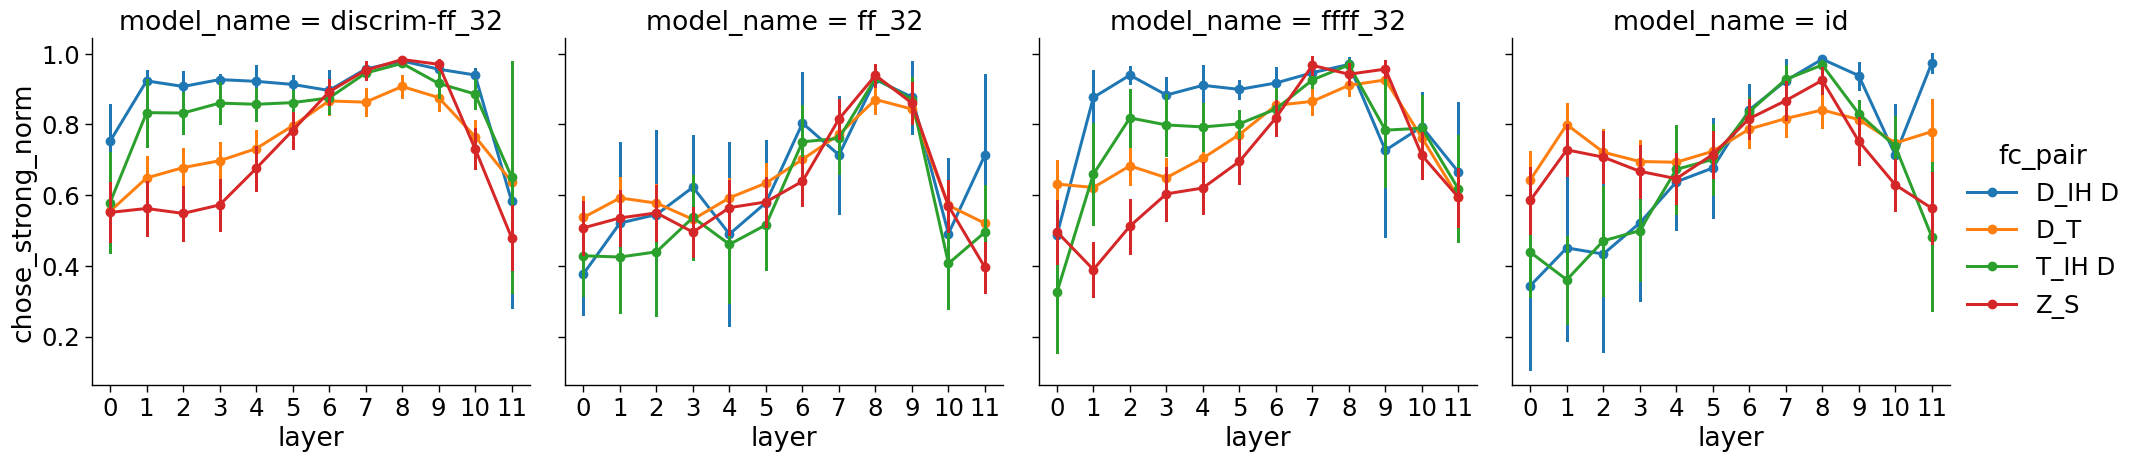

In [321]:
sns.catplot(data=fc_results.groupby(run_groupers + ["layer", "fc_pair", "base_to"]).apply(
    lambda xs: pd.Series({
        "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
        "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
    })) \
    .dropna().reset_index(),
    x="layer", col="model_name", y="chose_strong_norm", hue="fc_pair", kind="point", errorbar="se")

### Exploration

In [322]:
focus_fc_results = fc_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")

In [323]:
focus_fc_results.groupby("fc_pair").sample(4)[["fc_pair", "base_to", "inflected_to", "strong_item_to", "weak_item_to", "base_from", "inflected_from", "predicted_label", "chose_strong", "chose_weak"]]

fc_pair base_to inflected_to             strong_item_to   weak_item_to  \
341939  D_IH D    pain       pained                     pained  painted paint   
343760  D_IH D    live        lived                      lived          livid   
343399  D_IH D    pain       pained                     pained  painted paint   
341456  D_IH D    live        lived                      lived          livid   
340362     D_T    juan         wand                       wand    want wonted   
341010     D_T     tie         tide                  tide tied          tight   
340580     D_T      we         weed                  we'd weed          wheat   
340348     D_T    coal         cold                       cold           colt   
346476  T_IH D    flew        flute                     flewed    fluid flute   
346668  T_IH D     rap      wrapped  rapped rapt wrapped wrapt          rapid   
343877  T_IH D    pain        paint                     pained  painted paint   
346064  T_IH D    pain        paint                     pained  painted paint   
336213     Z_S    peer        peers                      peers         pierce   
337262     Z_S     jew         jews                 jew's jews          juice   
336114     Z_S    true       true's                     true's          truce   
336091     Z_S  decree      decrees                    decrees       decrease   

       base_from inflected_from predicted_label  chose_strong  chose_weak  
341939       lay           laid          pained          True       False  
343760     knock        knocked           lived          True       False  
343399     knock        knocked          pained          True       False  
341456      plow         plowed           lived          True       False  
340362      wood         wooded          wanton         False       False  
341010     cease         ceased            tide          True       False  
340580    streak       streaked            we'd          True       False  
340348    alight       alighted            cold          True       False  
346476  announce      announced          flowed         False       False  
346668     cease         ceased         wrapped          True       False  
343877    tangle        tangled          pained          True       False  
346064    preach       preached          pained          True       False  
336213      page          pages           peers          True       False  
337262      risk          risks            jews          True       False  
336114    sledge        sledges          virtue         False       False  
336091       tax          taxes        beauties         False       False

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

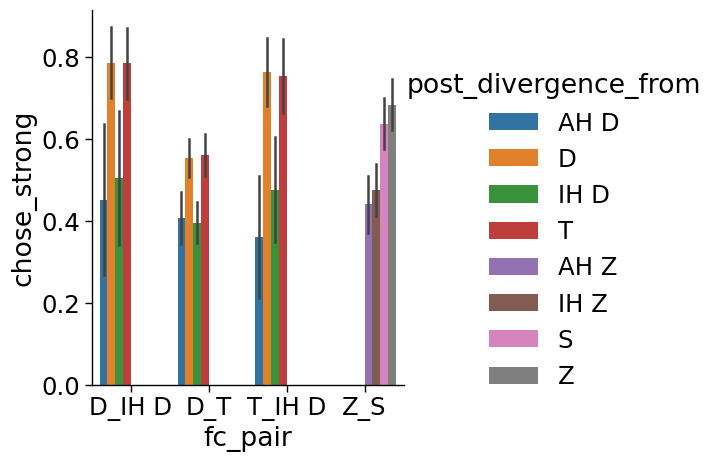

In [324]:
sns.catplot(data=focus_fc_results.groupby(["fc_pair", "post_divergence_from", "base_to"]).chose_strong.mean().dropna().reset_index(),
            x="fc_pair", hue="post_divergence_from", y="chose_strong", kind="bar", errorbar="se")

In [ ]:
# fc_results_by_word = fc_results.groupby(run_groupers + ["layer", "fc_pair", "base_to"]).apply(
#     lambda xs: pd.Series({
#         "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
#         "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum(),
#         "chose_strong_or_weak_proportion": xs.chose_strong_or_weak.mean(),
#     }))
# fc_results_by_word = fc_results_by_word[fc_results_by_word.chose_strong_or_weak_proportion > 0.1] \
#     .dropna().reset_index().sort_values("chose_strong_norm").assign(run_name=lambda xs: xs.model_name + " " + xs.layer.map("{:02d}".format))

# g = sns.FacetGrid(data=fc_results_by_word, col="fc_pair", row="run_name",
#                   row_order=sorted(fc_results_by_word.run_name.unique()),
#                   height=12, aspect=0.6, sharey=False)
# def f(data, **kwargs):
#     sns.heatmap(data=data.set_index("base_to")[["chose_strong_norm", "chose_weak_norm"]],
#                 vmin=0, vmax=1, cbar=False, **kwargs)
# g.map_dataframe(f)

/tmp/ipykernel_2075327/2987038157.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_2075327/2987038157.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_2075327/2987038157.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fc_results_by_word = fc_results.groupby(run_groupers + ["layer", "fc_pair", "base_to"]).apply(


/tmp/ipykernel_483784/1310650070.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_483784/1310650070.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
/tmp/ipykernel_483784/1310650070.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fc_results_by_word_and_source = focus_fc_results.groupby(run_groupers + ["fc_pair", "post_divergence_from", "base_to"]).apply(
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you wil

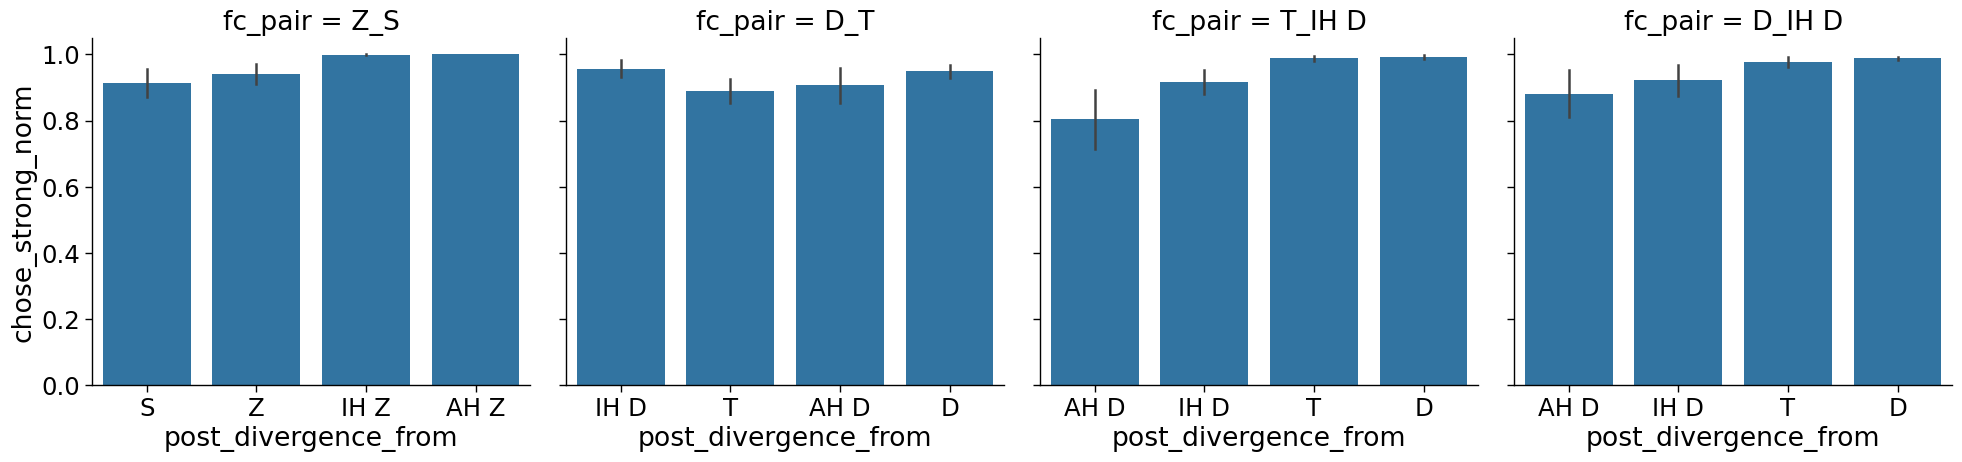

In [325]:
fc_results_by_word_and_source = focus_fc_results.groupby(run_groupers + ["fc_pair", "post_divergence_from", "base_to"]).apply(
    lambda xs: pd.Series({
        "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
        "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
    })) \
    .dropna().reset_index().sort_values("chose_strong_norm")

sns.catplot(data=fc_results_by_word_and_source,
            col="fc_pair", x="post_divergence_from", y="chose_strong_norm",
            kind="bar", errorbar="se", sharex=False)

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


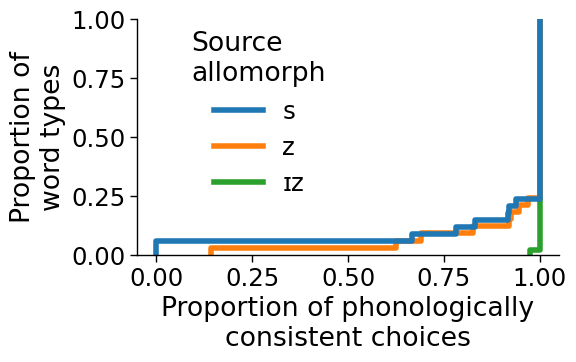

In [326]:
g = sns.displot(data=fc_results_by_word_and_source.query("fc_pair == 'Z_S'").assign(post_divergence_from=lambda xs: xs.post_divergence_from.map({"S": "s", "Z": "z", "IH Z": "ɪz", "AH Z": "ɪz"})),
                hue="post_divergence_from", x="chose_strong_norm",
                kind="ecdf", height=4, aspect=1.5, linewidth=4)

ax = g.axes.flat[0]
ax.set_xlabel("Proportion of phonologically\nconsistent choices")
ax.set_ylabel("Proportion of\nword types")
g.legend.set_title("Source\nallomorph")
g.legend.set_bbox_to_anchor((0.5, 0.6), transform=ax.transAxes)

g.tight_layout()
g.savefig(f"{output_dir}/fc_results-ecdf.pdf", bbox_inches="tight")

In [205]:
# sns.catplot(data=fc_results_by_word_and_source.query("fc_pair == 'Z_S'").assign(post_divergence_from=lambda xs: xs.post_divergence_from.map({"S": "s", "Z": "z", "IH Z": "ɪz", "AH Z": "ɪz"})),
#             col="fc_pair", y="post_divergence_from", x="chose_strong_norm",
#             kind="swarm", height=7, sharex=False)

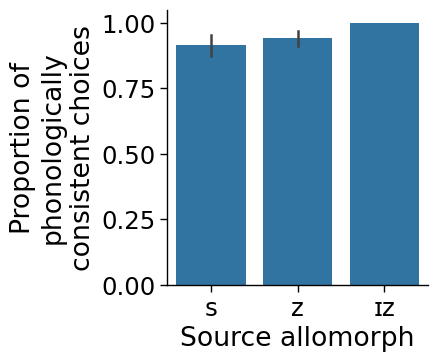

In [327]:
g = sns.catplot(data=fc_results_by_word_and_source.query("fc_pair == 'Z_S'").assign(post_divergence_from=lambda xs: xs.post_divergence_from.map({"S": "s", "Z": "z", "IH Z": "ɪz", "AH Z": "ɪz"})),
                x="post_divergence_from", y="chose_strong_norm",
                kind="bar", errorbar="se", sharex=False, height=4)

ax = g.axes.flat[0]
ax.set_ylabel("Proportion of\nphonologically\nconsistent choices")
ax.set_xlabel("Source allomorph")

g.savefig(f"{output_dir}/fc_results_by_word_and_source-Z_S.pdf", bbox_inches="tight")

In [324]:
# g = sns.FacetGrid(data=fc_results_by_word_and_source, col="fc_pair", row="post_divergence_from",
#                   height=12, aspect=0.6, sharey=False)
# def f(data, **kwargs):
#     sns.heatmap(data=data.set_index("base_to")[["chose_strong_norm", "chose_weak_norm"]],
#                 vmin=0, vmax=1, cbar=False, **kwargs)
# g.map_dataframe(f)

### Frequency analysis

In [127]:
fc_results = pd.merge(fc_results, word_freq_df.LogFreq.rename("from_base_freq"),
                            left_on="base_from", right_index=True)
fc_results = pd.merge(fc_results, word_freq_df.LogFreq.rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
fc_results = pd.merge(fc_results, word_freq_df.LogFreq.rename("to_base_freq"),
                              left_on="base_to", right_index=True)
fc_results = pd.merge(fc_results, word_freq_df.LogFreq.rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

In [128]:
fc_results["from_freq"] = fc_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
fc_results["to_freq"] = fc_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, fc_frequency_bins = pd.qcut(pd.concat([fc_results.to_freq, fc_results.from_freq]), q=4, retbins=True)
fc_results["from_freq_bin"] = pd.cut(fc_results.from_freq, bins=fc_frequency_bins, labels=[f"Q{i}" for i in range(1, 5)])
fc_results["to_freq_bin"] = pd.cut(fc_results.to_freq, bins=fc_frequency_bins, labels=[f"Q{i}" for i in range(1, 5)])

In [129]:
focus_fc_results = fc_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")

/tmp/ipykernel_2075327/1612419627.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.catplot(data=focus_fc_results.groupby(["fc_pair", "post_divergence_from", "base_to", "from_freq_bin"]).apply(
/tmp/ipykernel_2075327/1612419627.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_2075327/1612419627.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
/tmp/ipykernel_2075327/1612419627.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_

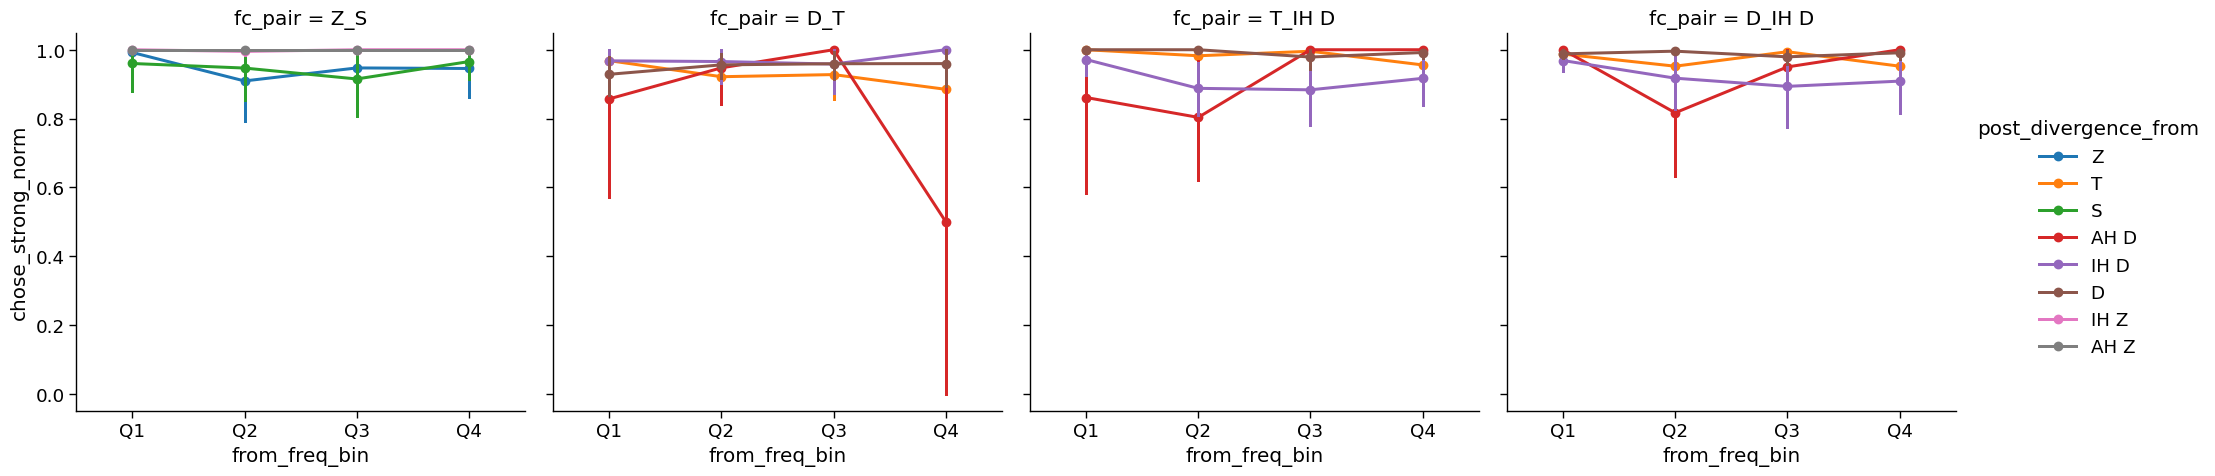

In [130]:
sns.catplot(data=focus_fc_results.groupby(["fc_pair", "post_divergence_from", "base_to", "from_freq_bin"]).apply(
    lambda xs: pd.Series({
        "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
        "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
    })) \
    .dropna().reset_index().sort_values("chose_strong_norm"),
    x="from_freq_bin", y="chose_strong_norm", hue="post_divergence_from", col="fc_pair", kind="point")

/tmp/ipykernel_2075327/2122275798.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.catplot(data=focus_fc_results.groupby(["fc_pair", "post_divergence_from", "base_to", "to_freq_bin"]).apply(
/tmp/ipykernel_2075327/2122275798.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_2075327/2122275798.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
/tmp/ipykernel_2075327/2122275798.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_gr

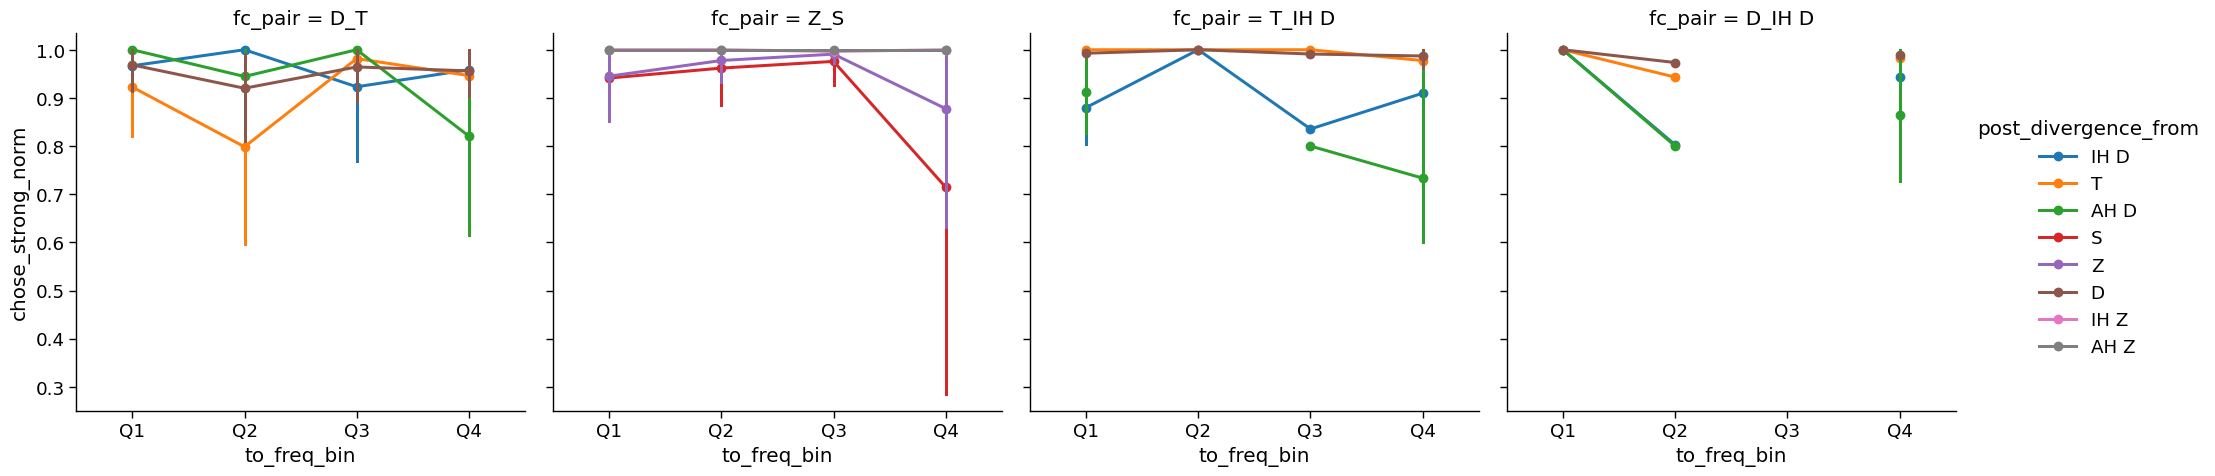

In [131]:
sns.catplot(data=focus_fc_results.groupby(["fc_pair", "post_divergence_from", "base_to", "to_freq_bin"]).apply(
    lambda xs: pd.Series({
        "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
        "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
    })) \
    .dropna().reset_index().sort_values("chose_strong_norm"),
    x="to_freq_bin", y="chose_strong_norm", hue="post_divergence_from",  col="fc_pair", kind="point")

## Exploratory for viz

In [315]:
expl = nnvb_focus.query("model_name == 'ffff_32' and ((inflection_from == 'VBZ' and inflection_to == 'NNS') or (inflection_from == 'NNS' and inflection_to == 'VBZ'))").reset_index()
expl.loc[expl.inflection_to == "NNS", "involved_noun"] = expl.base_to
expl.loc[expl.inflection_from == "NNS", "involved_noun"] = expl.base_from
expl.loc[expl.inflection_to == "NNS", "involved_allomorph"] = expl.allomorph_to
expl.loc[expl.inflection_from == "NNS", "involved_allomorph"] = expl.allomorph_from
expl["direction"] = expl.apply(lambda xs: "target" if xs.inflection_from == "VBZ" else "source", axis=1)
# only include stable counts
expl = expl.groupby(["involved_noun", "direction"]).filter(lambda xs: len(xs) > 5)
expl = expl.groupby(["involved_noun", "involved_allomorph", "direction"]).gt_label_rank.mean().unstack().dropna()
expl["ratio"] = (expl.target + 1) / (expl.source + 1)

In [323]:
expl.sort_values("ratio").head(10)

direction                             source    target     ratio
involved_noun involved_allomorph                                
friend        z                   110.166667  0.000000  0.008996
tank          s                    61.454545  0.388889  0.022238
bone          z                    71.625000  0.714286  0.023605
list          s                    46.647059  0.153846  0.024217
island        z                    36.000000  0.000000  0.027027
minute        s                    41.117647  0.315789  0.031241
expression    z                    30.428571  0.000000  0.031818
specimen      z                    28.833333  0.000000  0.033520
apple         z                    28.125000  0.000000  0.034335
disease       ɪz                   27.851852  0.000000  0.034660

In [324]:
expl.sort_values("ratio").tail(10)

direction                           source      target       ratio
involved_noun involved_allomorph                                  
pace          ɪz                  3.666667   33.029412    7.292017
hedge         ɪz                  2.548387   29.911765    8.711497
improvement   s                   3.761905   42.250000    9.082500
artery        z                   0.000000    8.625000    9.625000
fountain      z                   0.000000    9.000000   10.000000
boundary      z                   0.000000    9.142857   10.142857
extremity     z                   0.750000   19.500000   11.714286
canoe         z                   0.000000   14.857143   15.857143
shore         z                   0.000000   25.571429   26.571429
newspaper     z                   0.300000  176.125000  136.250000

In [319]:
expl.sort_values("target").head(6)

direction                            source  target     ratio
involved_noun involved_allomorph                             
expression    z                   30.428571     0.0  0.031818
heart         s                    8.437500     0.0  0.105960
hat           s                   12.058824     0.0  0.076577
habit         s                    9.647059     0.0  0.093923
guest         s                    8.210526     0.0  0.108571
gown          z                    0.000000     0.0  1.000000

In [322]:
expl.sort_values("source").head(6)

direction                         source     target      ratio
involved_noun involved_allomorph                              
bundle        z                      0.0   0.100000   1.100000
canoe         z                      0.0  14.857143  15.857143
boundary      z                      0.0   9.142857  10.142857
tale          z                      0.0   1.142857   2.142857
artery        z                      0.0   8.625000   9.625000
baker         z                      0.0   1.250000   2.250000

In [282]:
nnvb_focus.query("model_name == 'ffff_32' and base_to == 'cedar'").gt_label_rank.mean()

25.9

<Axes: xlabel='direction', ylabel='involved_noun'>

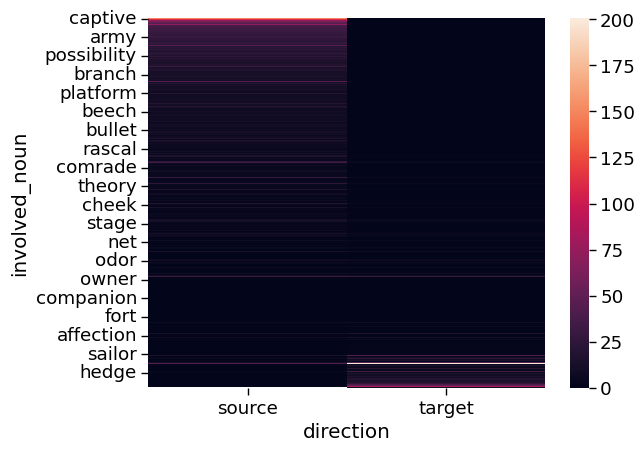

In [270]:
sns.heatmap(expl.sort_values("ratio")[["source", "target"]])

### Exploratory for viz 2

Find a noun N and a verb V for which performance is high within-inflection but for which transfer in one or both directions is poor.

In [335]:
nnvb_focus.query("model_name == 'ffff_32' and inflection_from == inflection_to") \
    .groupby(["inflection_from", "base_to"]).filter(lambda xs: len(xs) > 5) \
    .groupby(["inflection_from", "base_from"]).filter(lambda xs: len(xs) > 5)

index                     equivalence  \
experiment                                                                  
unambiguous-NNS_Z_to_NNS_Z        2995836  word_broad_10frames_fixedlen25   
unambiguous-NNS_Z_to_NNS_Z        2995839  word_broad_10frames_fixedlen25   
unambiguous-NNS_Z_to_NNS_Z        2995841  word_broad_10frames_fixedlen25   
unambiguous-NNS_Z_to_NNS_Z        2995842  word_broad_10frames_fixedlen25   
unambiguous-NNS_Z_to_NNS_Z        2995846  word_broad_10frames_fixedlen25   
...                                   ...                             ...   
unambiguous-VBZ_IH Z_to_VBZ_IH Z  3023249  word_broad_10frames_fixedlen25   
unambiguous-VBZ_IH Z_to_VBZ_IH Z  3023250  word_broad_10frames_fixedlen25   
unambiguous-VBZ_IH Z_to_VBZ_IH Z  3023251  word_broad_10frames_fixedlen25   
unambiguous-VBZ_IH Z_to_VBZ_IH Z  3023252  word_broad_10frames_fixedlen25   
unambiguous-VBZ_IH Z_to_VBZ_IH Z  3023253  word_broad_10frames_fixedlen25   

                                 model_name base_model_name  Unnamed: 1 group  \
experiment                                                                      
unambiguous-NNS_Z_to_NNS_Z          ffff_32          w2v2_8           0  None   
unambiguous-NNS_Z_to_NNS_Z          ffff_32          w2v2_8           3  None   
unambiguous-NNS_Z_to_NNS_Z          ffff_32          w2v2_8           5  None   
unambiguous-NNS_Z_to_NNS_Z          ffff_32          w2v2_8           6  None   
unambiguous-NNS_Z_to_NNS_Z          ffff_32          w2v2_8          10  None   
...                                     ...             ...         ...   ...   
unambiguous-VBZ_IH Z_to_VBZ_IH Z    ffff_32          w2v2_8           7  None   
unambiguous-VBZ_IH Z_to_VBZ_IH Z    ffff_32          w2v2_8           8  None   
unambiguous-VBZ_IH Z_to_VBZ_IH Z    ffff_32          w2v2_8           9  None   
unambiguous-VBZ_IH Z_to_VBZ_IH Z    ffff_32          w2v2_8          10  None   
unambiguous-VBZ_IH Z_to_VBZ_IH Z    ffff_32          w2v2_8          11  None   

                                               from_equiv_label  \
experiment                                                        
unambiguous-NNS_Z_to_NNS_Z            ('champion', 'champions')   
unambiguous-NNS_Z_to_NNS_Z        ('individual', 'individuals')   
unambiguous-NNS_Z_to_NNS_Z                ('turtle', 'turtles')   
unambiguous-NNS_Z_to_NNS_Z              ('quarter', 'quarters')   
unambiguous-NNS_Z_to_NNS_Z              ('laborer', 'laborers')   
...                                                         ...   
unambiguous-VBZ_IH Z_to_VBZ_IH Z       ('possess', 'possesses')   
unambiguous-VBZ_IH Z_to_VBZ_IH Z                 ('do', 'does')   
unambiguous-VBZ_IH Z_to_VBZ_IH Z          ('please', 'pleases')   
unambiguous-VBZ_IH Z_to_VBZ_IH Z                 ('do', 'does')   
unambiguous-VBZ_IH Z_to_VBZ_IH Z          ('please', 'pleases')   

                                                      to_equiv_label  \
experiment                                                             
unambiguous-NNS_Z_to_NNS_Z                     ('sister', 'sisters')   
unambiguous-NNS_Z_to_NNS_Z        ('contemporary', 'contemporaries')   
unambiguous-NNS_Z_to_NNS_Z               ('exception', 'exceptions')   
unambiguous-NNS_Z_to_NNS_Z                         ('pole', 'poles')   
unambiguous-NNS_Z_to_NNS_Z                     ('degree', 'degrees')   
...                                                              ...   
unambiguous-VBZ_IH Z_to_VBZ_IH Z               ('please', 'pleases')   
unambiguous-VBZ_IH Z_to_VBZ_IH Z               ('please', 'pleases')   
unambiguous-VBZ_IH Z_to_VBZ_IH Z                      ('do', 'does')   
unambiguous-VBZ_IH Z_to_VBZ_IH Z                 ('arise', 'arises')   
unambiguous-VBZ_IH Z_to_VBZ_IH Z                 ('arise', 'arises')   

                                   base_from       base_to  ...  \
experiment                                                  ...   
unambiguous-NNS_Z_to_NNS_Z          c

In [364]:
expl2 = nnvb_focus.query("model_name == 'ffff_32' and inflection_from == inflection_to") \
    .groupby(["inflection_from", "base_to"]).filter(lambda xs: len(xs) > 5) \
    .groupby(["inflection_from", "base_from"]).filter(lambda xs: len(xs) > 5) \

expl2 = pd.DataFrame({
    "target_rank": expl2.groupby(["inflection_from", "base_to"]).gt_label_rank.mean(),
    "source_rank": expl2.groupby(["inflection_from", "base_from"]).gt_label_rank.mean()
}).dropna()
expl2["ratio"] = (expl2.target_rank + 1) / (expl2.source_rank + 1)
expl2.index.names = ["inflection", "label"]

In [365]:
expl2.sort_values("ratio").head(10)

target_rank  source_rank     ratio
inflection label                                       
VBZ        begin        0.363636    20.642857  0.063006
           suggest      0.035088    15.245614  0.063715
NNS        vice         0.105263    16.193548  0.064284
           price        0.307692    17.846154  0.069388
VBZ        come         0.022222    11.369565  0.082640
           possess      0.701754    19.473684  0.083119
NNS        monument     0.071429    11.666667  0.084586
           horse        0.052632    10.000000  0.095694
           meadow       0.000000     9.166667  0.098361
VBZ        exist        0.000000     8.736842  0.102703

In [366]:
expl2.sort_values("ratio").tail(10)

target_rank  source_rank      ratio
inflection label                                         
NNS        cent          4.866667     0.125000   5.214815
           tyrant        8.708333     0.222222   7.943182
           hedge        11.806452     0.568182   8.166433
VBZ        own         283.234043    30.100000   9.139358
NNS        saint         9.190476     0.095238   9.304348
           expert       67.000000     4.904762  11.516129
           hen          12.714286     0.000000  13.714286
           buccaneer    15.428571     0.125000  14.603175
           insect       18.153846     0.066667  17.956731
           turnip       58.733333     0.142857  52.266667

In [367]:
expl2[(expl2.target_rank < 1) & (expl2.source_rank < 1)]

target_rank  source_rank     ratio
inflection label                                           
NNS        accident         0.000000     0.090909  0.916667
           achievement      0.833333     0.416667  1.294118
           acquaintance     0.030303     0.357143  0.759171
           activity         0.000000     0.000000  1.000000
           advantage        0.078947     0.024390  1.053258
...                              ...          ...       ...
VBZ        appear           0.476190     0.510204  0.977477
           become           0.050000     0.782609  0.589024
           eat              0.087719     0.438596  0.756098
           occur            0.023810     0.930233  0.530407
           remind           0.000000     0.837209  0.544304

[248 rows x 3 columns]

In [368]:
transfer_ranks = nnvb_focus.query("model_name == 'ffff_32' and inflection_from != inflection_to") \
    .groupby(["inflection_from", "base_to"]).filter(lambda xs: len(xs) > 5) \
    .groupby(["inflection_from", "base_from"]).filter(lambda xs: len(xs) > 5)

transfer_ranks = pd.DataFrame({
    "source_transfer_rank": transfer_ranks.groupby(["inflection_from", "base_from"]).gt_label_rank.mean(),
    "target_transfer_rank": transfer_ranks.groupby(["inflection_to", "base_to"]).gt_label_rank.mean()
}).dropna()
transfer_ranks.index.names = ["inflection", "label"]
transfer_ranks

source_transfer_rank  target_transfer_rank
inflection label                                                     
NNS        accident                    4.187500              0.000000
           accomplishment              7.875000              0.666667
           achievement                 7.500000              9.000000
           acquaintance                1.961538              2.580645
           advantage                   2.617647              0.621622
...                                         ...                   ...
VBZ        take                        0.494444              0.456989
           tell                        0.327586              0.030769
           tend                        0.353846              8.347222
           think                       0.161290              0.288043
           write                       0.446927             22.584270

[425 rows x 2 columns]

In [378]:
expl3 = pd.merge(expl2, transfer_ranks, left_index=True, right_index=True)
expl3["mean_within"] = (expl3.source_rank + expl3.target_rank) / 2
expl3["mean_transfer"] = (expl3.source_transfer_rank + expl3.target_transfer_rank) / 2
expl3["ratio"] = (expl3.mean_within + 1) / (expl3.mean_transfer + 1)

In [381]:
expl3[(expl3.target_rank < 1) & (expl3.source_rank < 1)]# & (expl3.source_transfer_rank > 1) & (expl3.target_transfer_rank > 1)].sort_values("ratio")

target_rank  source_rank     ratio  \
inflection label                                              
NNS        accident         0.000000     0.090909  0.337925   
           achievement      0.833333     0.416667  0.175676   
           acquaintance     0.030303     0.357143  0.364931   
           advantage        0.078947     0.024390  0.401456   
           adventure        0.250000     0.166667  0.128319   
...                              ...          ...       ...   
VBZ        appear           0.476190     0.510204  1.008303   
           become           0.050000     0.782609  1.305943   
           eat              0.087719     0.438596  0.657307   
           occur            0.023810     0.930233  1.391397   
           remind           0.000000     0.837209  0.997394   

                         source_transfer_rank  target_transfer_rank  \
inflection label                                                      
NNS        accident                  4.187500              0.000000   
           achievement               7.500000              9.000000   
           acquaintance              1.961538              2.580645   
           advantage                 2.617647              0.621622   
           adventure                12.333333              4.500000   
...                                       ...                   ...   
VBZ        appear                    0.135135              0.826667   
           become                    0.169014              0.000000   
           eat                       0.479798              1.363636   
           occur                     0.123077              0.000000   
           remind                    0.716418              0.128205   

                         mean_within  mean_transfer  
inflection label                                     
NNS        accident         0.045455       2.093750  
           achievement      0.625000       8.250000  
           acquaintance     0.193723       2.271092  
           advantage        0.051669       1.619634  
           adventure        0.208333       8.416667  
...                              ...            ...  
VBZ        appear           0.493197       0.480901  
           become           0.416304       0.084507  
           eat              0.263158       0.921717  
           occur            0.477021       0.061538  
           remind           0.418605       0.422312  

[188 rows x 7 columns]